In [190]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dupire Local Volatility Modeling

**The goal of this notebook is to build a prototype of a Dupire workflow.**
- From an option chain (using european call options on the S&P 500 ETF here), fit an SVI total implied variance curve for each maturity.
- From there, interpolate between each maturity to obtain a volatilty implied surface
- Derive the Dupire local vol from this volatility surface

The code of this notebook relies on the qtools modules. Feel free to download and run the notebook with it

In [191]:
import yfinance as yf
import pandas as pd
import pdb
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import qtools.options as op
import qtools.black_scholes as bs
import qtools.numerical as numerical
import qtools.svi as svi

## Option Data Loading & Cleaning

### Data Preparation

In [192]:
call = op.OptionType.EUROPEAN_CALL
put = op.OptionType.EUROPEAN_PUT

In [193]:
#Working with maturities 30 days, 2 months, 3 months, 6 months, 8M, 1Y: 
# Following code is put as comment to ensure reproductibility of the following work, given that fetch_option_data relies on live yfinance data 
"""
dates = ["2026-02-13", "2026-03-20", "2026-04-17",  "2026-06-30", "2026-09-18", "2027-01-15"]
df = op.fetch_option_data("SPY", dates, call)
"""

'\ndates = ["2026-02-13", "2026-03-20", "2026-04-17",  "2026-06-30", "2026-09-18", "2027-01-15"]\ndf = op.fetch_option_data("SPY", dates, call)\n'

In [194]:
# The CSV was created using op.fetch_option_data("SPY", dates, call) :  ACOMG1919H69YM1J
df = pd.read_csv("SPY_option_chain.csv")

In [195]:
df.dropna(inplace = True)

In [196]:
quote_list = op.to_quote(df, 0.02,  valuation_date = "2026-01-12", ticker="SPY")

In [197]:
book = op.OptionBook(quote_list)

In [198]:
book = book.compute_iv(keep_nan=False)

/Users/fantinsibony/Library/CloudStorage/Dropbox/github/qtools/project_root/qtools/src/qtools/black_scholes.py:171: VolSolverWarning:

Arbitrage Error : market price 406.845 for upper bound 694.4400024414062 and lower bound 435.3927729979399. Returned value is np.nan

/Users/fantinsibony/Library/CloudStorage/Dropbox/github/qtools/project_root/qtools/src/qtools/black_scholes.py:171: VolSolverWarning:

Arbitrage Error : market price 401.96500000000003 for upper bound 694.4400024414062 and lower bound 430.41109550864246. Returned value is np.nan

/Users/fantinsibony/Library/CloudStorage/Dropbox/github/qtools/project_root/qtools/src/qtools/black_scholes.py:171: VolSolverWarning:

Arbitrage Error : market price 398.515 for upper bound 694.4400024414062 and lower bound 425.42941801934506. Returned value is np.nan

/Users/fantinsibony/Library/CloudStorage/Dropbox/github/qtools/project_root/qtools/src/qtools/black_scholes.py:171: VolSolverWarning:

Arbitrage Error : market price 349.435 for up

In [199]:
book

<OptionBook> with 641 quotes

In [200]:
unique_T = book.unique_T() #sorted by unique_T()

### Data Visualisation

In [201]:
plt.style.use('dark_background')

In [202]:
maturities = {}
for mat, t in zip(["1M", "2M", "3M", "6M", "8M", "1Y"], unique_T):
    maturities[mat] = t

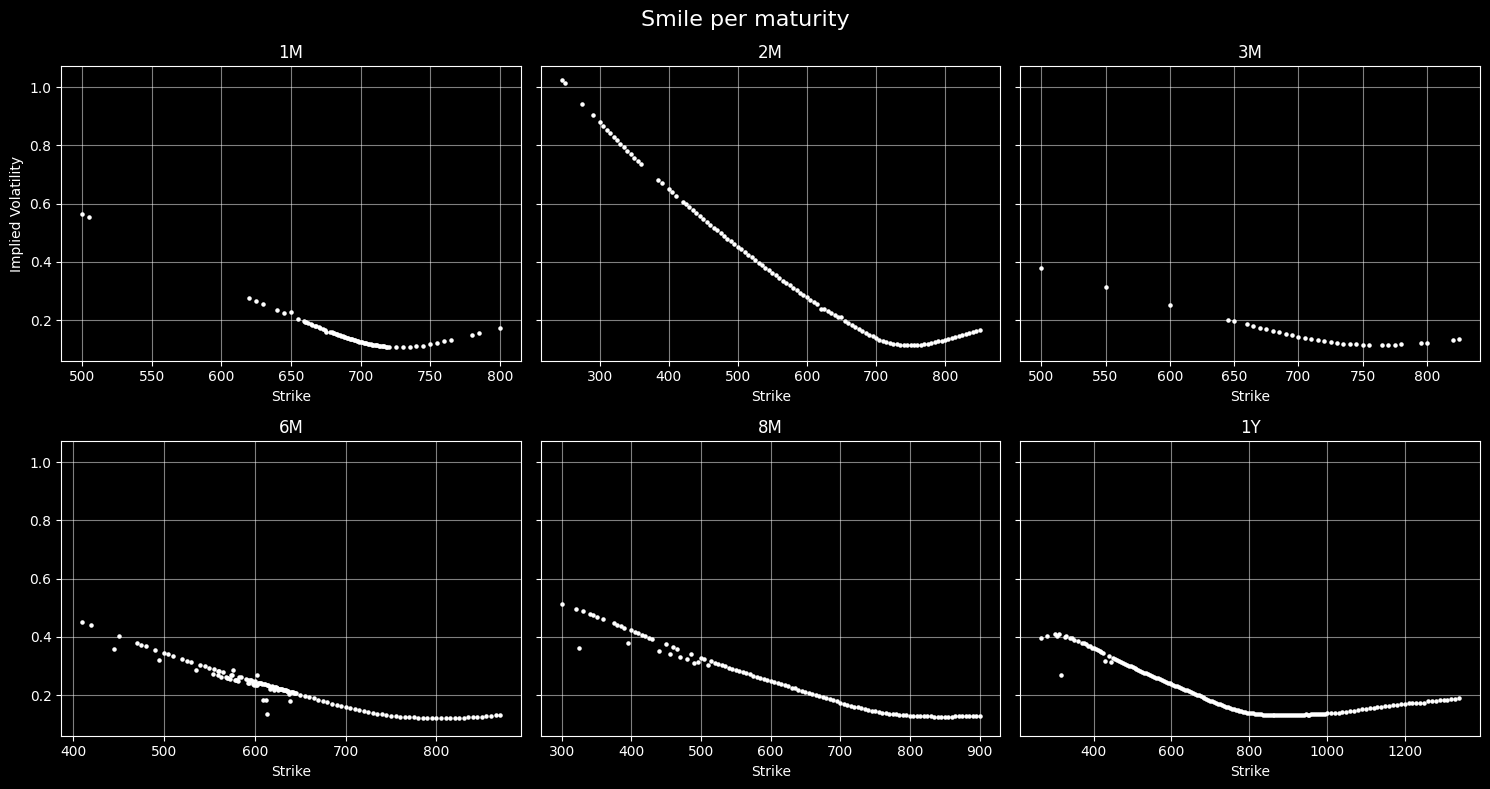

In [203]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for ax, t in zip(axes,maturities):
    sub_book = book[book.T == maturities[t]]

    K = sub_book.K
    iv = sub_book.iv

    ax.scatter(K, iv, marker="o", color = 'white', s = 5)
    ax.set_title(t)
    ax.set_xlabel("Strike")
    ax.grid(alpha = 0.5)

axes[0].set_ylabel("Implied Volatility")

fig.suptitle("Smile per maturity", fontsize=16)
plt.tight_layout()
plt.show()

In [204]:

K = book.K
T = book.T
IV = book.iv
F = book.F
LM = book.LM
r_spread = book.spread/book.market_prices

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=K,
        y=T,
        z=IV,
        mode="markers",
        marker=dict(size=3, color = "white"),
        name="options"
    )
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Strike (K)",
        yaxis_title="Time to maturity (years)",
        zaxis_title="Implied volatility",
        aspectmode = 'manual',
        aspectratio=dict(x=2, y = 1, z=1)
    ),
    height=800
)

fig.show()

In [205]:
white_to_red = [
    [0.0, "#f7f7f7"],
    [0.5, "#fcae91"],
    [1.0, "#cb181d"],
]

cmin = np.quantile(r_spread, 0.05)
cmax = np.quantile(r_spread, 0.95)

In [206]:

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=K,
        y=T,
        z=IV,
        mode="markers",
            marker=dict(
            size=3,
            color=r_spread,
            cmin = cmin,
            cmax = cmax,
            colorscale=white_to_red,
            colorbar = dict(title = "Relative Spread"),
            showscale=True
        ),
        name="options"
    )
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Strike (K)",
        yaxis_title="Time to maturity (years)",
        zaxis_title="Implied volatility",
        aspectmode = 'manual',
        aspectratio=dict(x=2, y = 1, z=1)
    ),
    height=800
)

fig.show()

## Data Cleaning

We will proceed with data cleaning in two steps:
- The first step will consist in removing quotes that are likely to lack trustworthiness. This includes quotes which are highly illiquid. In order to do that, we will filter by log-moneyness and by bid-ask spread : options log-moneyness that is not in [-0.2; 0.2] and relative spread > 20% will be excluded. 
- In a second time, we will clean the remaining points to ensure that our data exhibits sufficiently strong characteristic to be used in Dupire (notably in terms of $\frac{\partial_C}{\partial_K}$ and $\frac{\partial_w}{\partial_k}$)

In [207]:
lm_window = 0.2

mask_LM = (LM < -lm_window) | (LM > lm_window)
mask_spread = (r_spread > 0.2)

mask_keep = (~mask_LM) & (~mask_spread)
mask_LM_only = mask_LM & (~mask_spread)
mask_spread_only = mask_spread

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=LM[mask_keep],
        y=T[mask_keep],
        z=IV[mask_keep],
        mode="markers",
        marker=dict(size=3, color="white"),
        name="kept"
    )
)

fig.add_trace(
    go.Scatter3d(
        x=LM[mask_LM_only],
        y=T[mask_LM_only],
        z=IV[mask_LM_only],
        mode="markers",
        marker=dict(size=3, color="red"),
        name="filtered (LM)"
    )
)

fig.add_trace(
    go.Scatter3d(
        x=LM[mask_spread_only],
        y=T[mask_spread_only],
        z=IV[mask_spread_only],
        mode="markers",
        marker=dict(size=3, color="#d9ff00"),
        name="filtered (spread)"
    )
)

Tmin, Tmax = float(T.min()), float(T.max())
IVmin, IVmax = float(IV.min()), float(IV.max())

y = np.linspace(Tmin, Tmax, 2)
z = np.linspace(IVmin, IVmax, 2)
Y, Z = np.meshgrid(y, z)

X_left  = np.full_like(Y, -lm_window)
X_right = np.full_like(Y,  lm_window)

fig.add_trace(
    go.Surface(
        x=X_left,
        y=Y,
        z=Z,
        opacity=0.25,
        colorscale=[[0, "gray"], [1, "gray"]],
        showscale=False,
        hoverinfo="skip",
        name="k = -0.2"
    )
)

fig.add_trace(
    go.Surface(
        x=X_right,
        y=Y,
        z=Z,
        opacity=0.25,
        colorscale=[[0, "gray"], [1, "gray"]],
        showscale=False,
        hoverinfo="skip",
        name="k = +0.2"
    )
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k = log(K/F)",
        yaxis_title="Time to maturity (years)",
        zaxis_title="Implied volatility",
        aspectmode="manual",
        aspectratio=dict(x=2, y=1, z=1)
    ),
    height=800
)

fig.show()


#### Spline on C(K) 

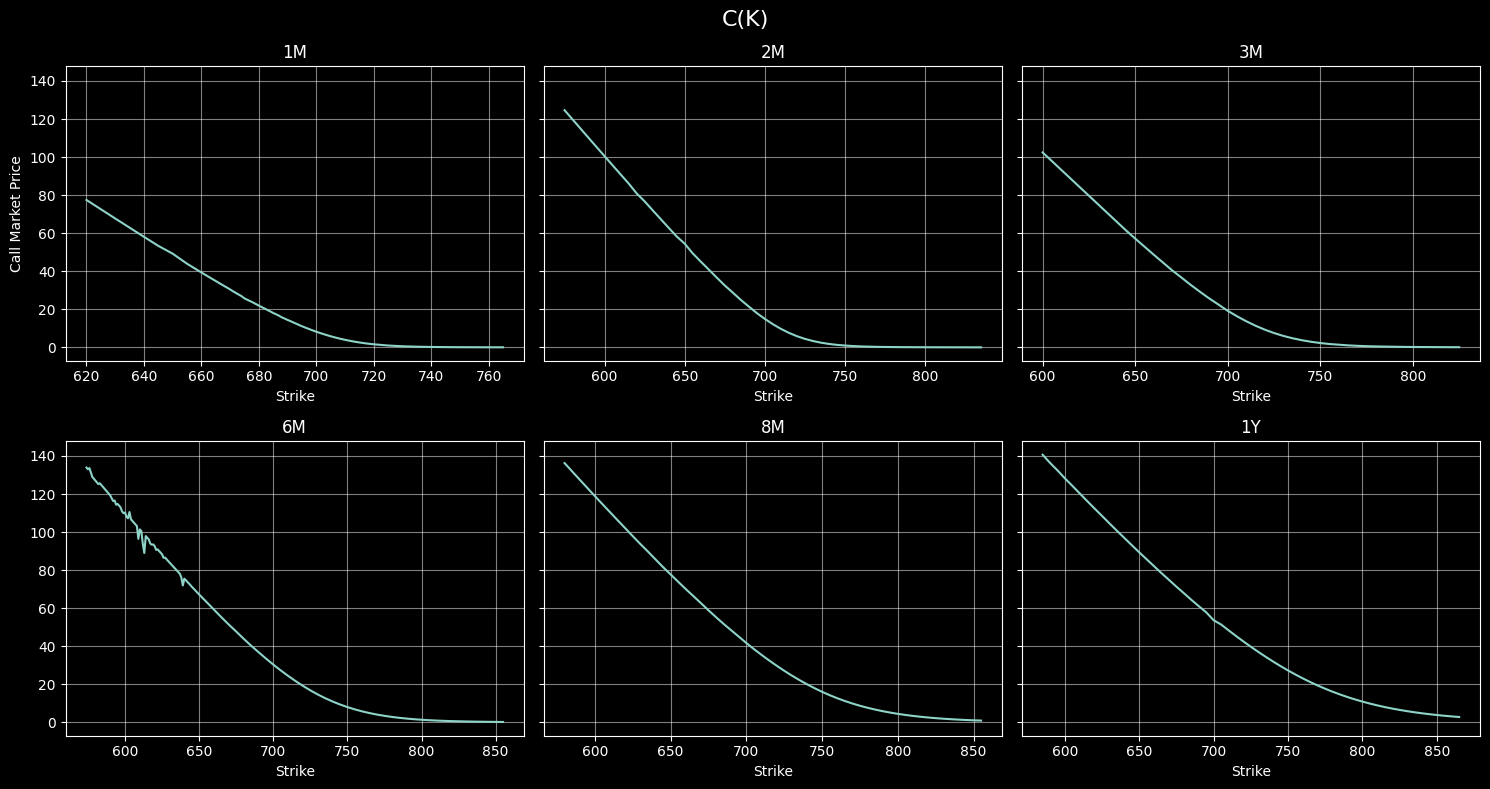

In [208]:
book_clean = book[mask_keep]


fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()


for ax, t in zip(axes, maturities):

    sub_book = book_clean[book_clean.T == maturities[t]]
    K = sub_book.K
    C = sub_book.market_prices
    ax.plot(K, C)
    ax.set_title(t)
    ax.set_xlabel("Strike")
    ax.grid(alpha = 0.5)

axes[0].set_ylabel("Call Market Price")
axes[0].set_xlabel("Strike")

fig.suptitle("C(K)", fontsize=16)
plt.tight_layout()
plt.show()


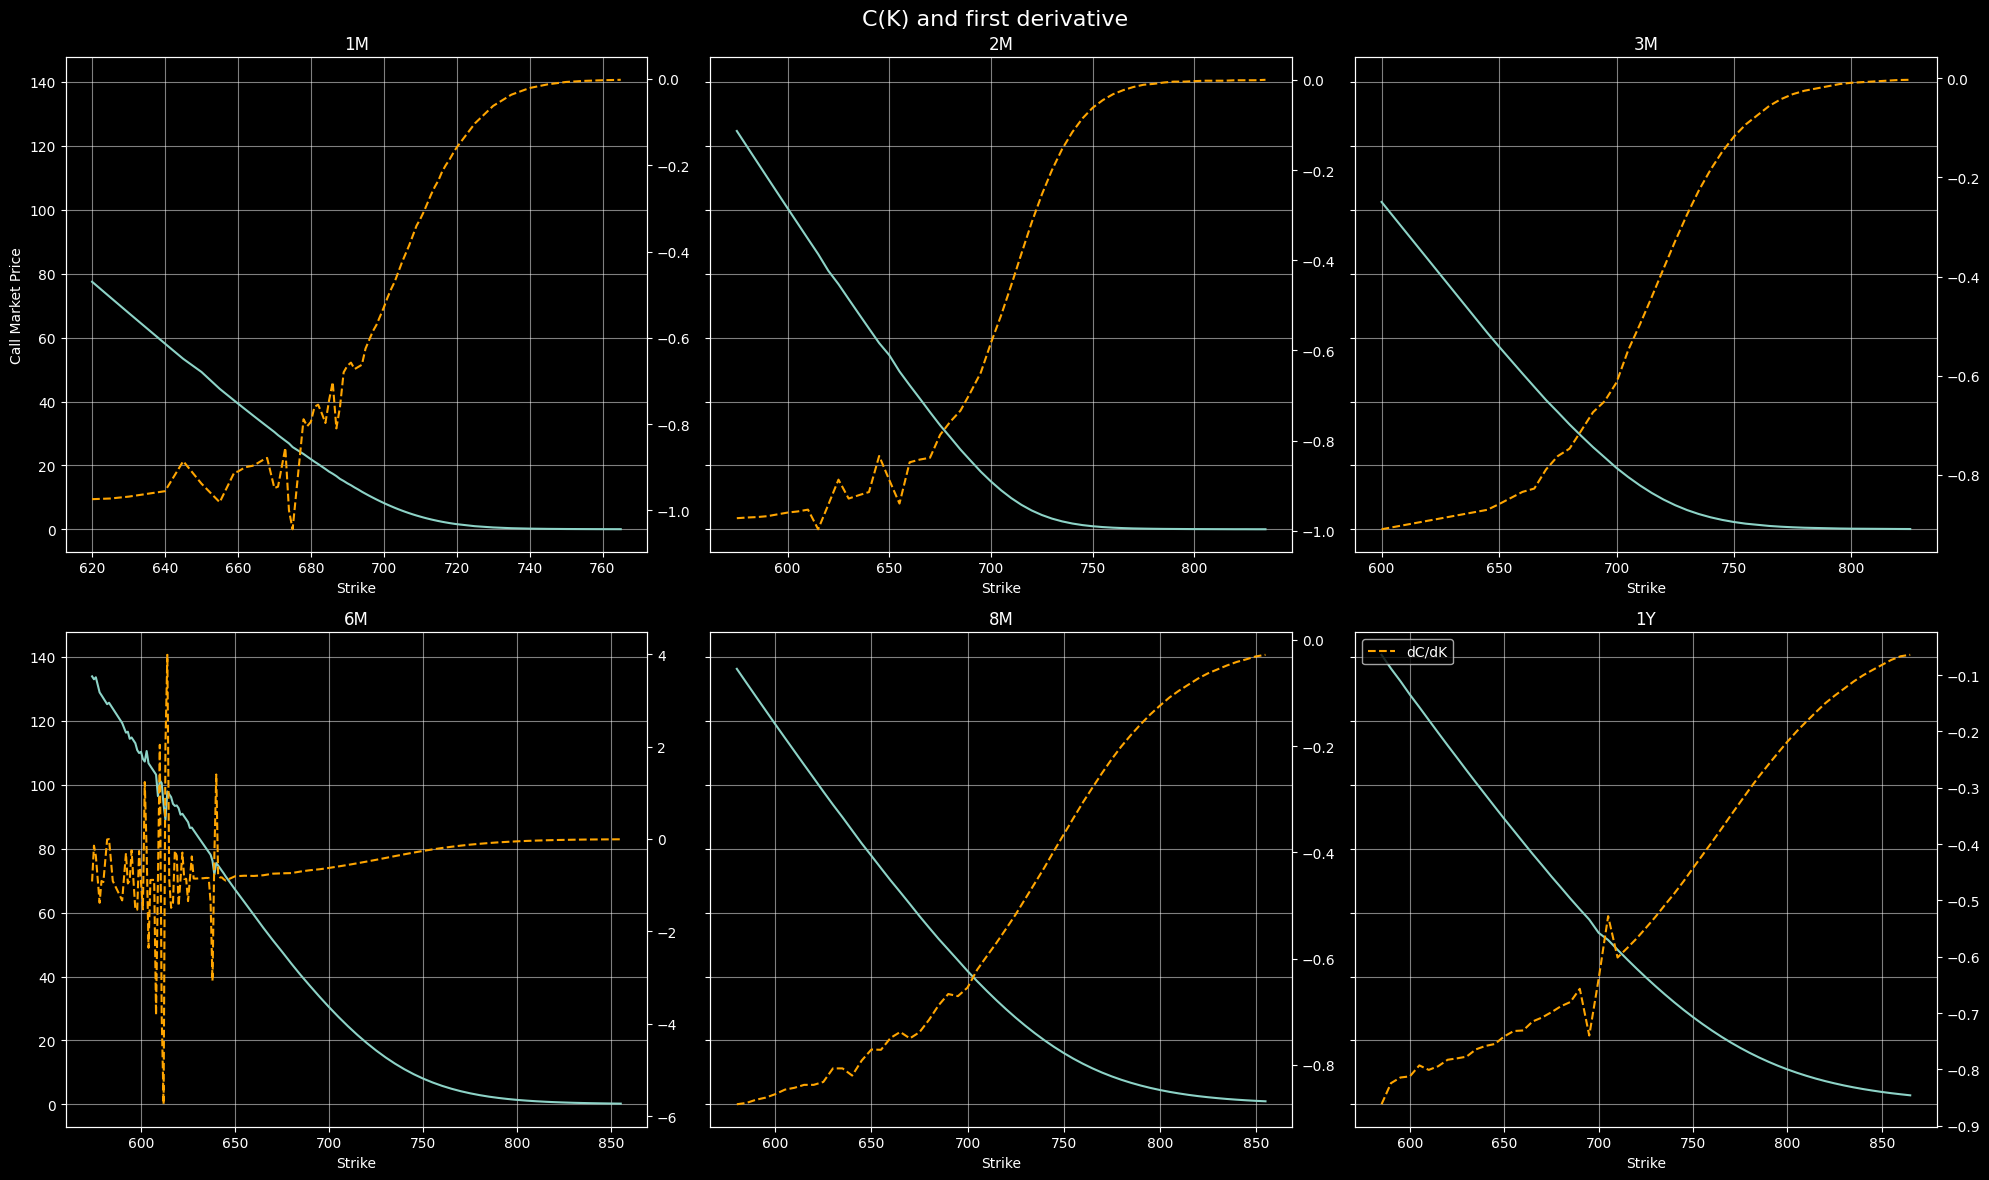

In [209]:

fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
axes = axes.flatten()

for ax, mat in zip(axes, maturities):
    sub_book = book_clean[book_clean.T == maturities[mat]]

    K = np.asarray(sub_book.K, dtype=float)
    C = np.asarray(sub_book.market_prices, dtype=float)

    idx = np.argsort(K)
    K = K[idx]
    C = C[idx]

    dC_dK = np.gradient(C, K)

    ax.plot(K, C, label="C(K)")
    ax2 = ax.twinx()
    ax2.plot(K, dC_dK, linestyle="--", label="dC/dK", color = "orange")

    ax.set_title(mat)
    ax.set_xlabel("Strike")
    ax.grid(alpha=0.5)

axes[0].set_ylabel("Call Market Price")

fig.suptitle("C(K) and first derivative", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

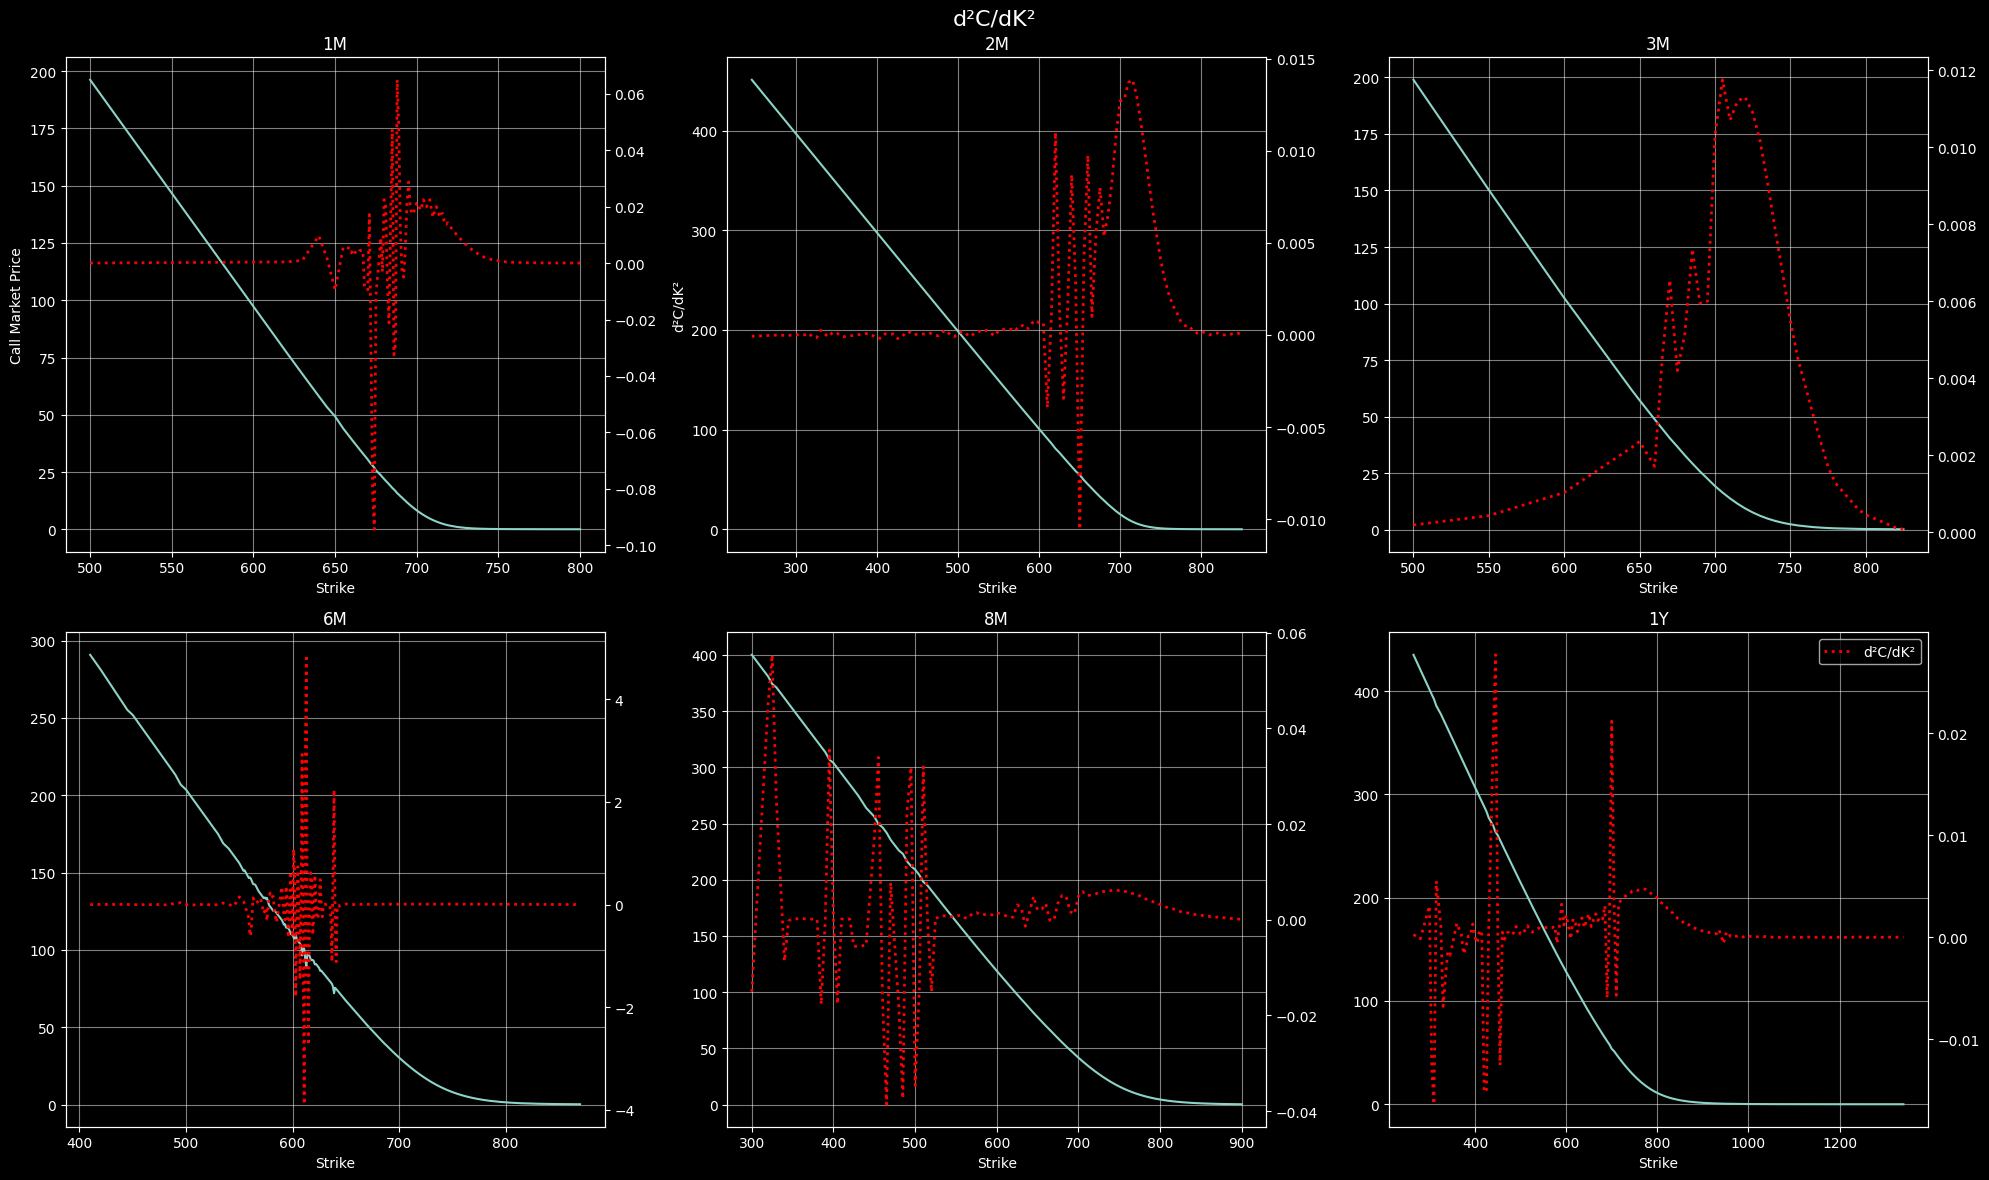

In [210]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()

for ax, mat in zip(axes, maturities):
    sub_book = book[(book.T == maturities[mat])]

    K = np.asarray(sub_book.K, dtype=float)
    C = np.asarray(sub_book.market_prices, dtype=float)

    idx = np.argsort(K)
    K = K[idx]
    C = C[idx]

    dC_dK = np.gradient(C, K)
    d2C_dK2 = np.gradient(dC_dK, K)
    ax.plot(K, C, label="C(K)")
    ax2 = ax.twinx()
    ax2.plot(K, d2C_dK2, linestyle=":", label="d²C/dK²", color = "red",lw = 2)


    ax.set_title(mat)
    ax.set_xlabel("Strike")
    ax.grid(alpha=0.5)

axes[0].set_ylabel("Call Market Price")
axes[1].set_ylabel("d²C/dK²")

fig.suptitle("d²C/dK²", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

Our data shows strong noise, and mutliple arbitrage violation. Before moving forward, we therefore need to smooth the market price/strike relationship to make sure that the data is arbitrage free. 

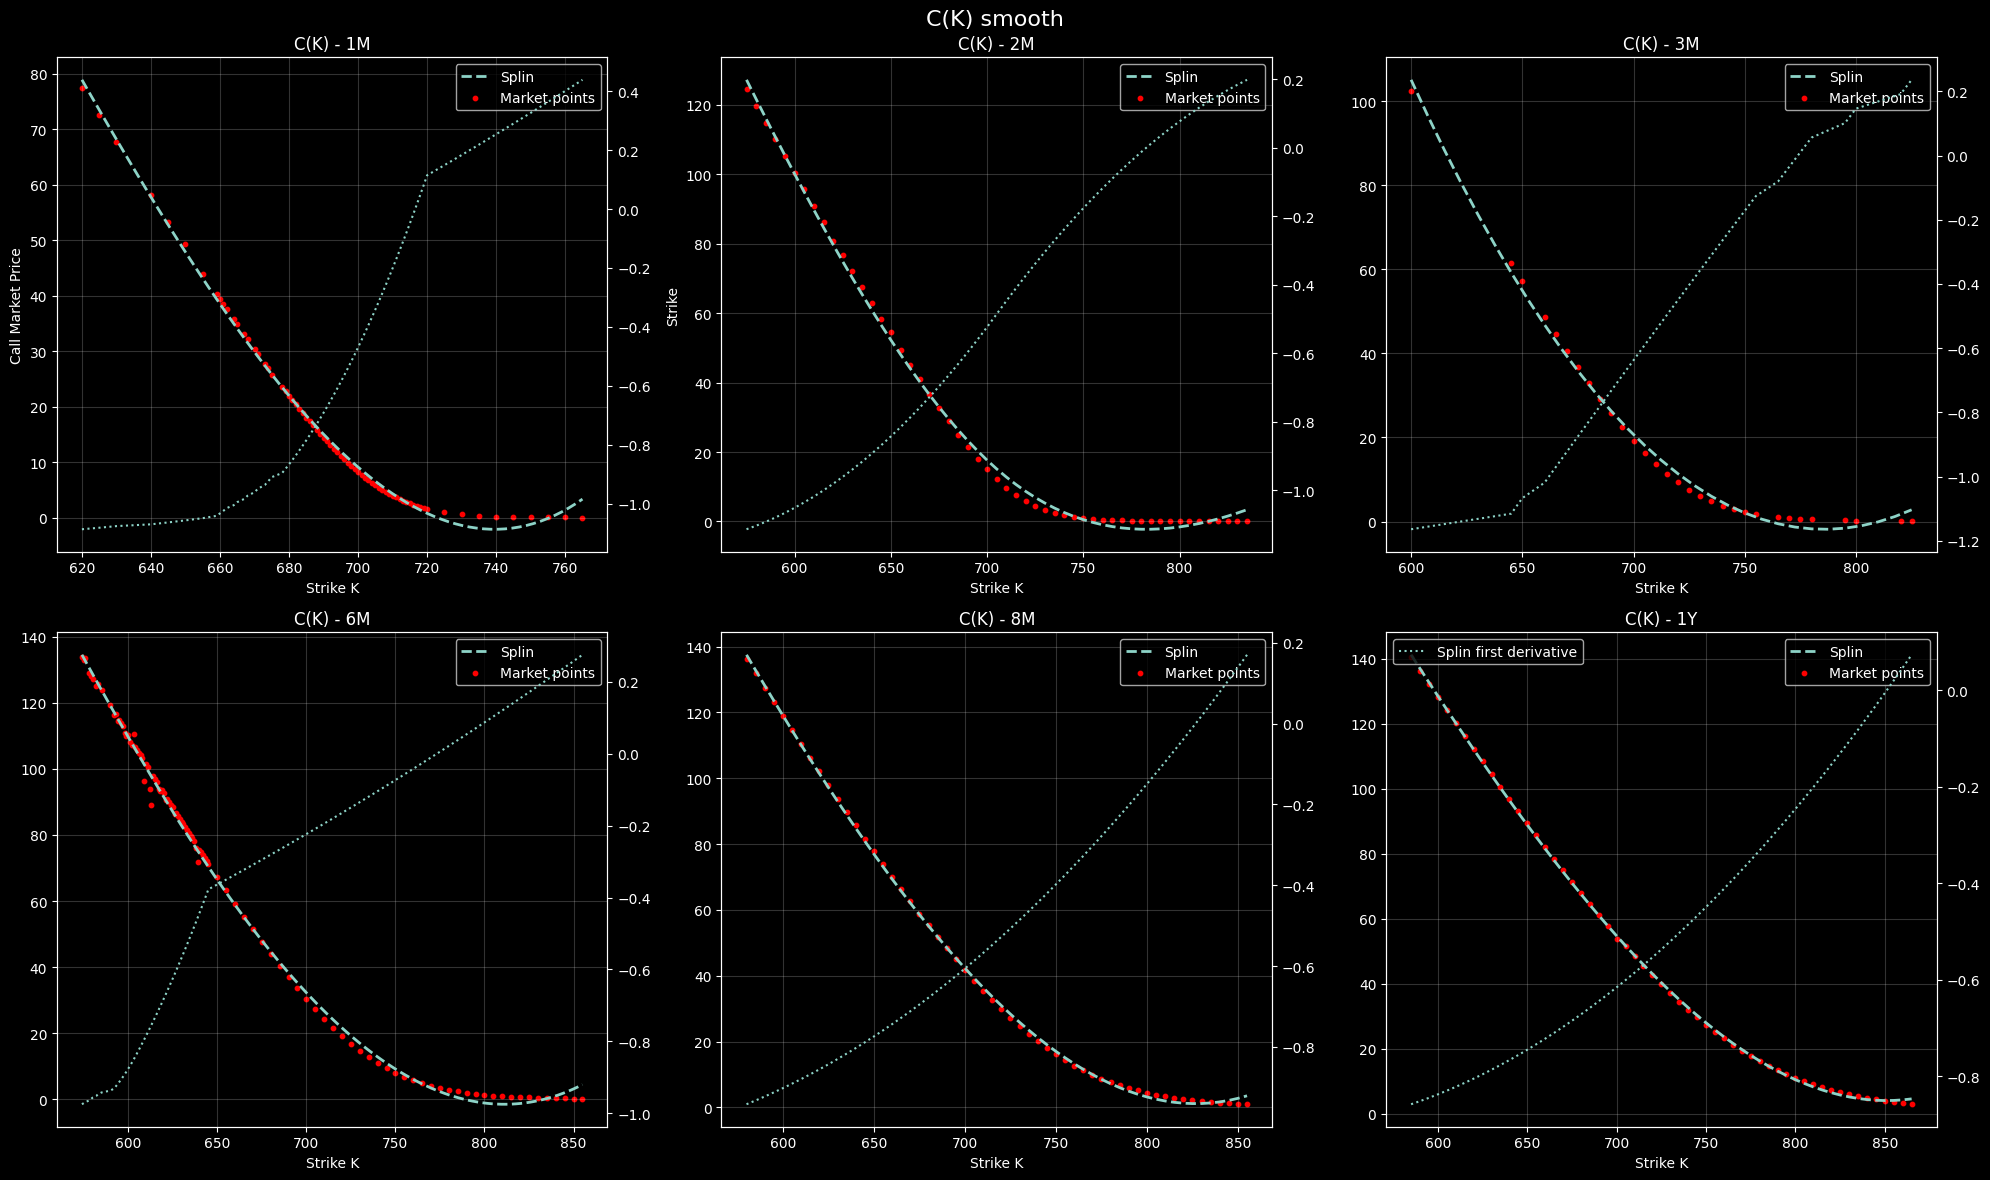

In [211]:
from scipy.interpolate import UnivariateSpline
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()

d2C_dK2_per_mat = {}

for ax, t in zip(axes, maturities):
    sub_book = book_clean[book_clean.T == maturities[t]]
    K = sub_book.K
    C = sub_book.market_prices

    spl = UnivariateSpline(x = K, y = C,k = 3,s = 3.2*len(K))

    K_fine = np.linspace(K.min(), K.max(), len(K))
    C_smooth = spl(K_fine)

    #Computing the spline derivatives
    dC_dK   = spl.derivative(n=1)(K_fine)
    d2C_dK2 = spl.derivative(n=2)(K_fine)
    d2C_dK2_per_mat[t] = d2C_dK2


    ax.plot(K_fine, C_smooth, '--', lw=2, label='Splin')
    ax.scatter(K, C, s= 10, color = "red", label='Market points')
    ax.set_title(f"C(K) - {t}")
    
    ax2 = ax.twinx()
    ax2.plot(K, dC_dK, ":", label="Splin first derivative")
    
    
    ax.legend()
    ax.grid(alpha = .2)


    ax.set_xlabel("Strike K")

axes[0].set_ylabel("Call Market Price")
axes[1].set_ylabel("Strike")

fig.suptitle("C(K) smooth", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

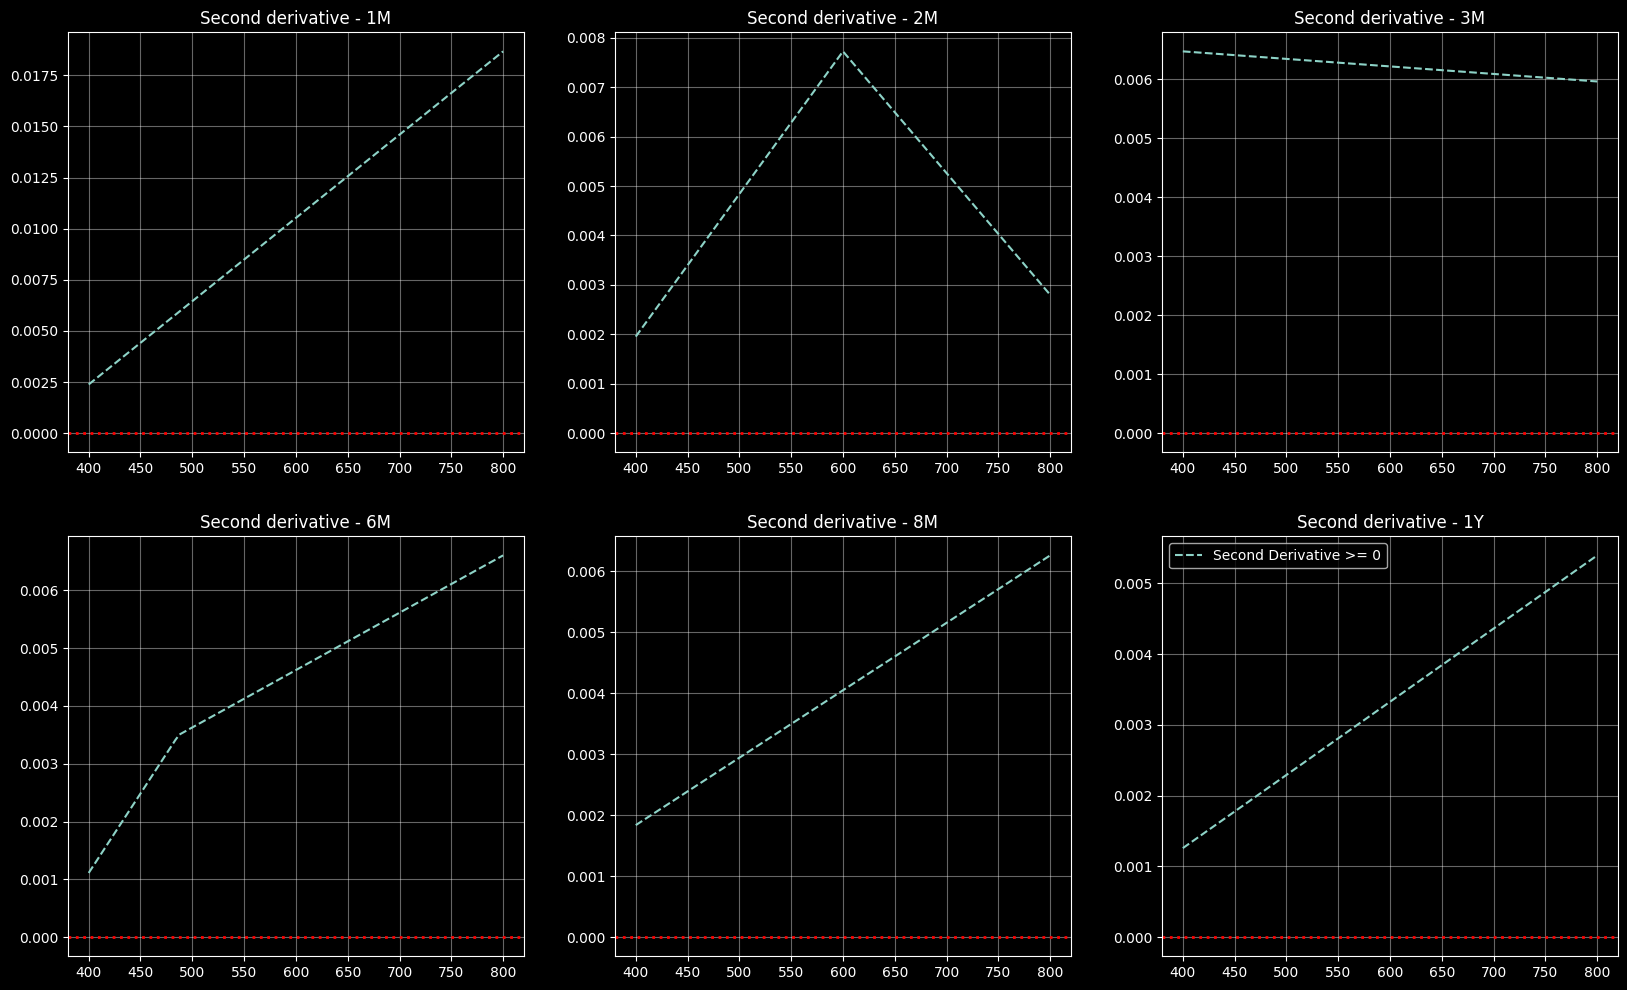

In [212]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()

for ax, t in zip(axes, maturities):
    d2C_dK2 = d2C_dK2_per_mat[t]
    K_fine = np.linspace(400, 800, len(d2C_dK2))

    is_neg = (d2C_dK2 >= 0)
    ax.plot(K_fine, d2C_dK2, '--', label="Second Derivative >= 0")
    #ax.plot(K_fine[is_neg], d2C_dK2[is_neg], '--', label="Second Derivative >= 0")
    #ax.plot(K_fine[~is_neg], d2C_dK2[~is_neg], '--', color = "orange", label="Second Derivative < 0")
    ax.axhline(0, linestyle=":", color='red', lw=2)
    ax.set_title(f"Second derivative - {t}")
    ax.grid(alpha= 0.4)
plt.legend()
plt.show()


#### Spline on w(k)

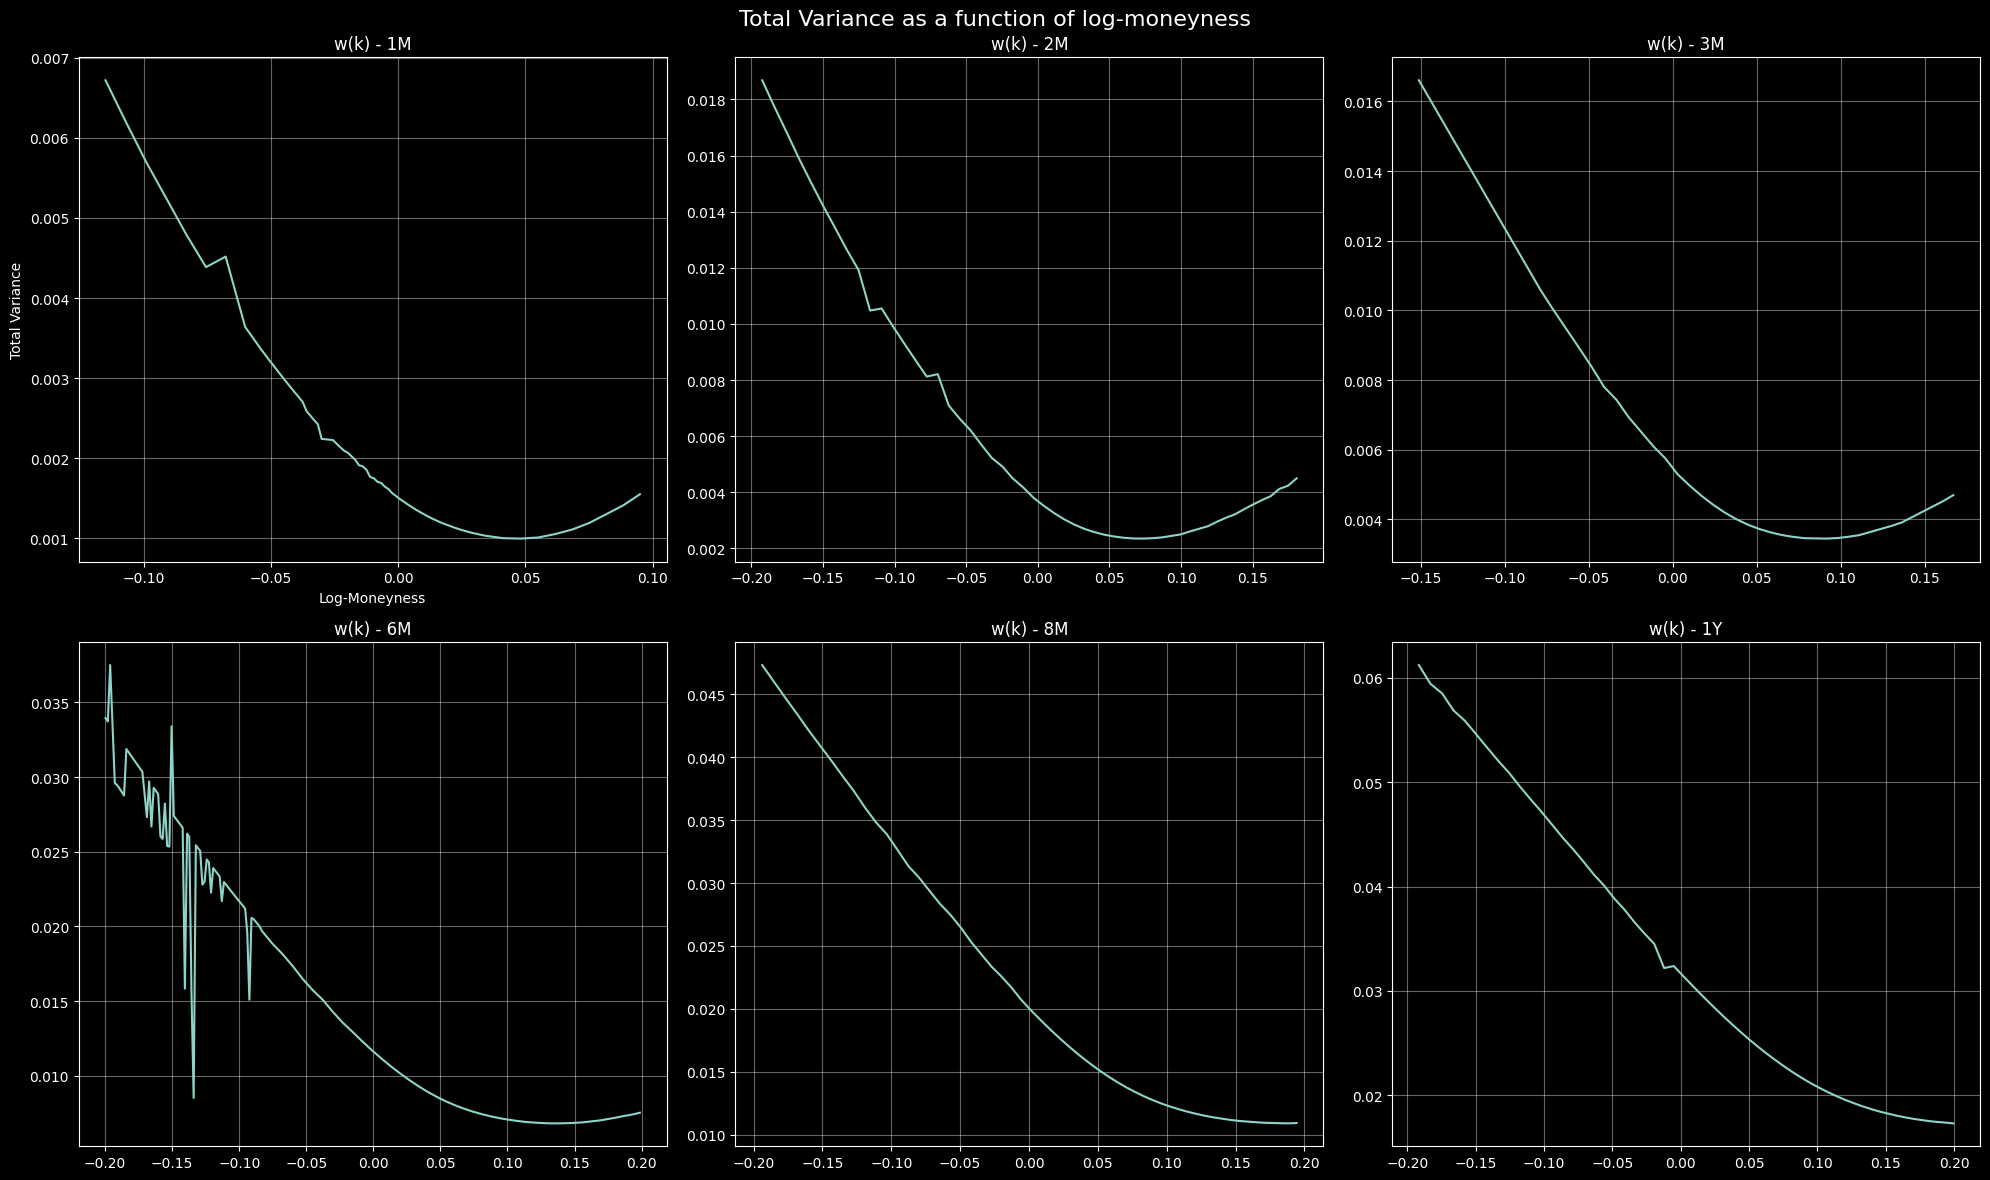

In [213]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()


for ax, t in zip(axes, maturities):
    sub_book = book_clean[book_clean.T == maturities[t]]
    k = sub_book.LM
    iv = sub_book.iv
    W = sub_book.W #total variance

    ax.set_title(f'w(k) - {t}')
    
    ax.plot(k, W)
    ax.grid(alpha =0.4) 

axes[0].set_ylabel("Total Variance")
axes[0].set_xlabel("Log-Moneyness")


plt.suptitle("Total Variance as a function of log-moneyness", fontsize = 16)
plt.tight_layout()
plt.show()    


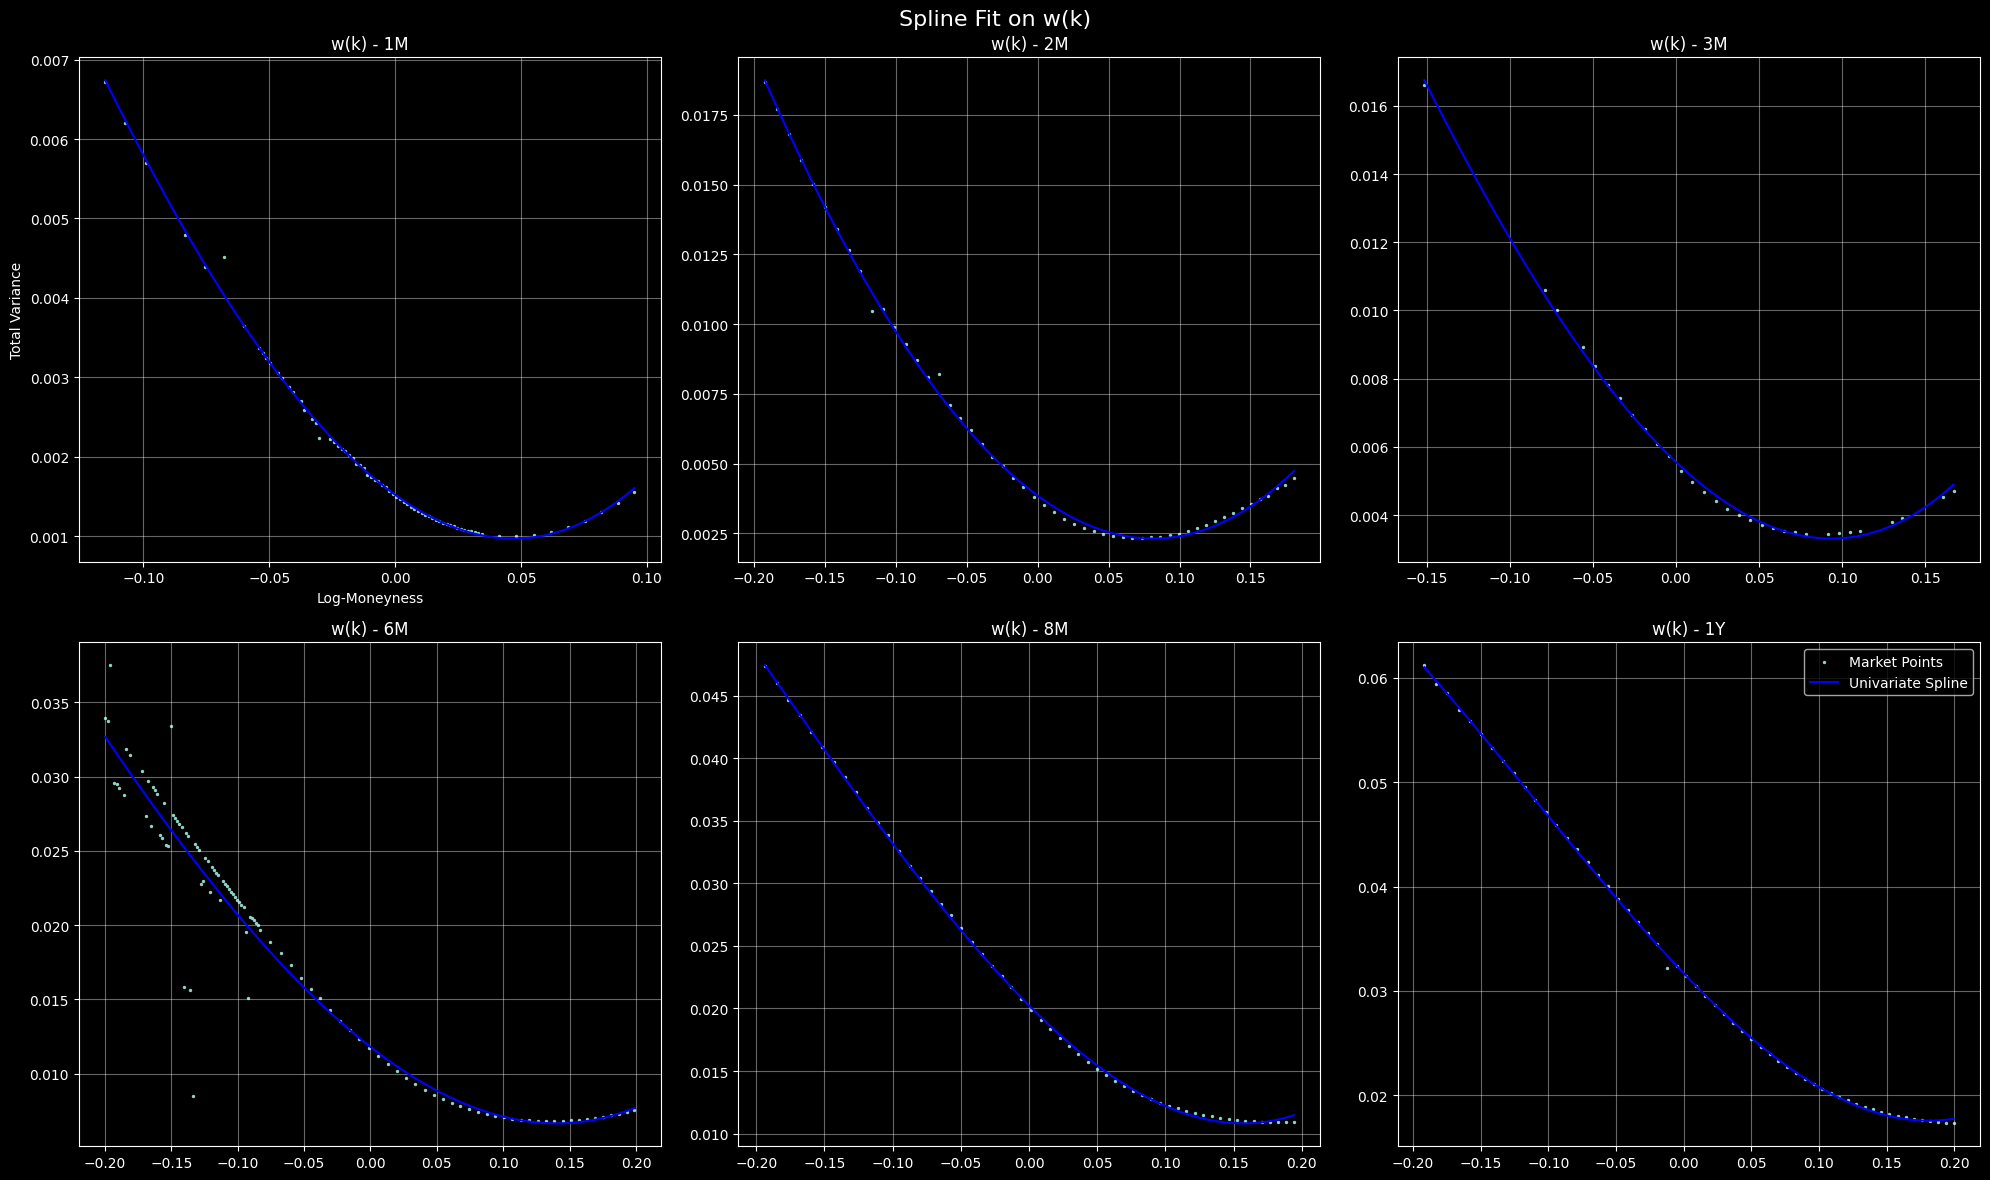

In [214]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()

spline_per_mat = {}
for ax, t in zip(axes, maturities):
    sub_book = book_clean[book_clean.T == maturities[t]]
    k = sub_book.LM
    iv = sub_book.iv
    W = sub_book.W #total variance

    idx = np.argsort(k)
    k = k[idx]
    W = W[idx]

    spl = UnivariateSpline(k, W)

    k_grid_spline = np.linspace(k.min(), k.max(), 200)
    W_grid_spline = spl(k_grid_spline)
    dw_dk = spl.derivative(n=1)(k_grid_spline)
    dw_dkk = spl.derivative(n=2)(k_grid_spline)

    spline_per_mat[t] = spl
    
    ax.set_title(f'w(k) - {t}')
    ax.scatter(k, W, marker='o', s = 2, label = 'Market Points')
    ax.plot(k_grid_spline, W_grid_spline, "-", color = "blue", label = "Univariate Spline")
    ax.grid(alpha =0.4) 

    #ax2 = ax.twinx()

    #ax2.plot(k_grid_spline, dw_dkk,":", color = "orange", label="Second derivative of spline fit")
    #ax2.plot(k_grid_spline, dw_dk,"--", color = "lightblue", label="First derivative of w(k)")

axes[0].set_ylabel("Total Variance")
axes[0].set_xlabel("Log-Moneyness")
plt.suptitle("Spline Fit on w(k)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()    

#### Filtering with spline

In [215]:
residuals_mask = []

c = 4  # coefficient by which to multiply MAD to keep/drop the point

for t in maturities:
    sub_book = book_clean[book_clean.T == maturities[t]]
    k = sub_book.LM
    W = sub_book.W  # total variance

    spl = spline_per_mat[t]
    W_spline = spl(k)

    r = (W - W_spline) / W_spline
    r_centralised = r - np.median(r)

    mad = np.median(np.abs(r_centralised))  # Median Absolute Deviation

    m = (np.abs(r_centralised) <= c * mad) #Keep == true if r_centralised error is inferior to c * Mean Absolute Deviation
    residuals_mask.extend(m)

residuals_mask = np.array(residuals_mask)

In [216]:
print(f"Removed with residual mask : {len(residuals_mask) - sum(residuals_mask)} | Keeping {len(book_clean[residuals_mask])} quotes")

Removed with residual mask : 16 | Keeping 359 quotes


### Final Working Data

In [217]:
work_book = book_clean[residuals_mask]
del_res_points = book_clean[~residuals_mask]

In [218]:
work_book

<OptionBook> with 359 quotes

In [219]:
K = work_book.K
T = work_book.T
IV = work_book.iv
F = work_book.S * np.exp(work_book.r * T)
LM = np.log(K / F)
r_spread = work_book.spread/work_book.market_prices


fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=LM,
        y=T,
        z=IV,
        mode="markers",
            marker=dict(
            size=3,
            color=r_spread,
            colorscale=white_to_red,
            colorbar = dict(
                title = "Relative Spread"
            ),
            showscale=True
        ),
        name="options"
    )
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k = log(K/F)",
        yaxis_title="Time to maturity (years)",
        zaxis_title="Implied volatility",
        aspectmode = 'manual',
        aspectratio=dict(x=2, y = 1, z=1)
    ),
    height=800
)

fig.show()

In [220]:
ice_to_blue = [
    [0.0, "#f0f8ff"],
    [0.3, "#d0e8ff"],
    [0.6, "#a0d0ff"],
    [1.0, "#4169e1"]
]

In [221]:
W = IV**2 * T

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=LM,
        y=T,
        z=W,
        mode="markers",
            marker=dict(
            size=3,
            color=T,
            colorscale=ice_to_blue,
            showscale=True
        ),
        name="options"
    )
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k = log(K/F)",
        yaxis_title="Time to maturity (years)",
        zaxis_title="Total Variance",
        aspectmode = 'manual',
        aspectratio=dict(x=2, y = 1, z=1)
    ),
    height=800
)

fig.show()

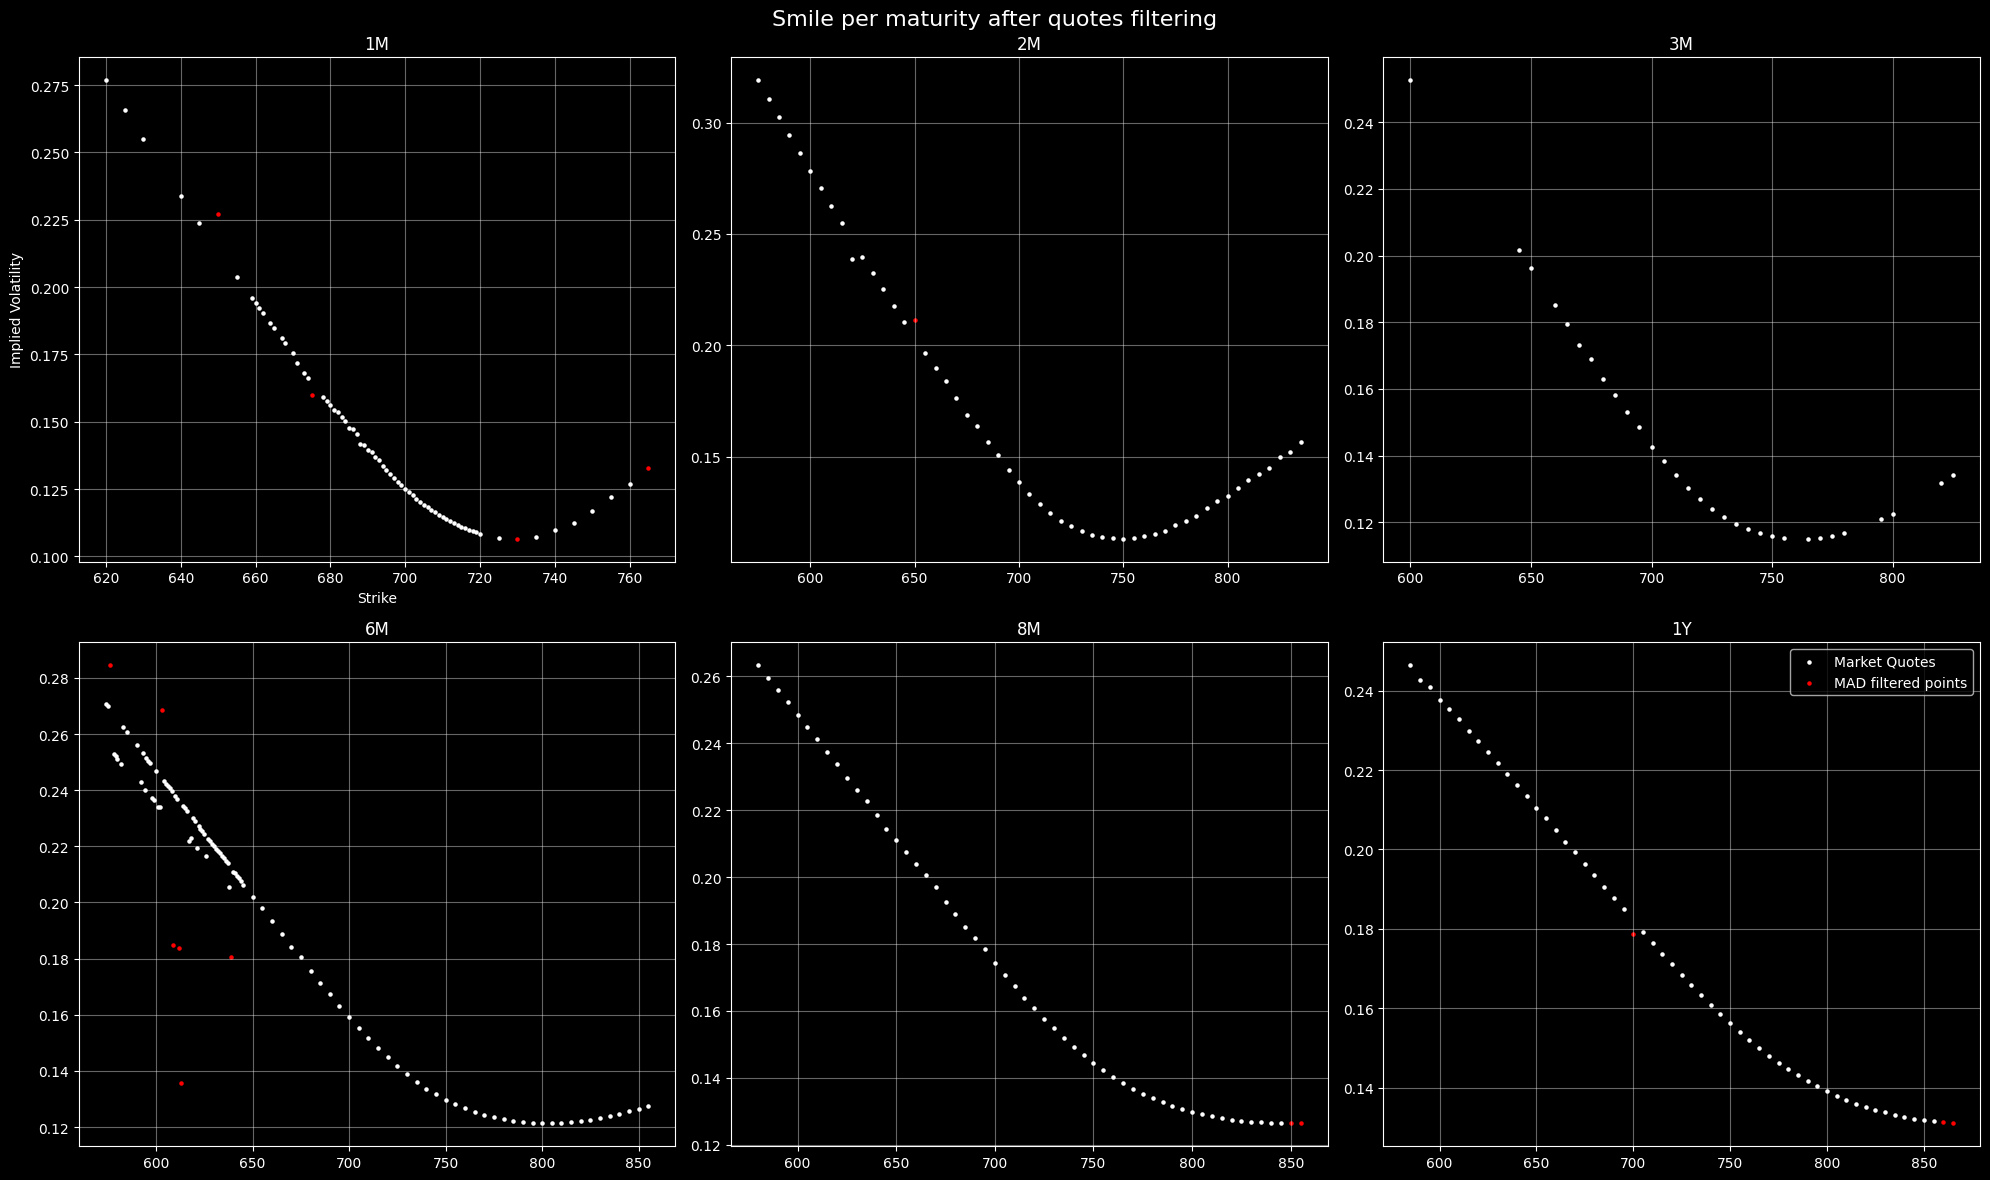

In [222]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=False)
axes = axes.flatten()


for ax, t in zip(axes, maturities):
    sub_book = work_book[work_book.T == maturities[t]]
    sub_book_rem = del_res_points[del_res_points.T == maturities[t]]

    K = sub_book.K
    iv = sub_book.iv

    K_rem = sub_book_rem.K
    iv_rem = sub_book_rem.iv

    ax.set_title(f'{t}')
    
    ax.scatter(K, iv, s = 5, color = "white", label="Market Quotes")
    ax.scatter(K_rem, iv_rem, s = 5, color = "red", label = "MAD filtered points")

    ax.grid(alpha =0.4) 

axes[0].set_ylabel("Implied Volatility")
axes[0].set_xlabel("Strike")


plt.suptitle("Smile per maturity after quotes filtering", fontsize = 16)
plt.legend()
plt.tight_layout()
plt.show()    


We have a good smile visualisation, but we can notice strong noise for OTM calls at maturity T = 6M.

## SVI

In order to modelise the smile of the options, we will proceed in two steps.

- We will first fit a SVI curve per maturity. We will prioritize near-ATM options over the wings, as some of the data exhibits signs of "dirty quotes" in the wings (especially at t = 6M). For each maturity/slice, we will compute the residuals between total variance from our points and from the SVI curve.
- We will then filter the points slice by slice using the median absolute deviation of the residuals; again, we will preserve ATM options and focus on filtering outlying quotes on the wings. 
- Finally, with our filtered points, we will fit a SSVI model.

We start by a first "naive" fit with default initialisation parameters.

For the first fit, we will try with two methods :
- The first approach will perfom a "naive fit" for the parameters : with $\theta$ the vector of parameters to estimate, $W_{target}$ the target total variance and $w(k, \theta)$ the function that computes total implied variance from log-moneyness k and parameters $\theta$, the ``svi_fit()`` method will call `scipy.least_squares` to solve 

$$ \min_{\theta} \sum_{i} (w(k_i, \theta) - W_{target, i})^2$$

- In the second approach, we will add a normalisation option and a weight vector to svi_fit() so that the residual function to minimize becomes
$$\min_{\theta} \sum_i \sqrt{\omega_i} \frac{(w(k_i, \theta) - W_{target, i})^2}{\max(W_{target, i}, \epsilon)}$$

with $\epsilon > 0$ to ensure numerical stability and $\omega$ a weight vector passed to the function

The rationale to minimize the squared error as a percentage of $W_{target}$ instead of the raw value is to ensure the fit will try to minimize each point equally, and will not favor points with higher values for total variance. For the weight vector, we will take into account two considerations : favor options that are near ATM and options with lower spread to give more importance to cleaner quotes. Our weight vector hence will be 

$$ \omega_i = \omega_i^{spread} \times \omega_i^{ATM} $$

with:
$$ \omega_i^{spread} = \frac{1}{\epsilon + (rs_i) ^{2}} $$


$rs_i$ being the relative spread of option $i$

And

$$\omega_i^{ATM} = exp(-\frac{k_i^{2}}{2\sigma_k^{2}}) $$



In [223]:
# Fitting the SVI curve per maturity : for convenience, we will fit both in the same loop

slices_list_with_norm = {}
slices_list_no_norm = {}

for t in unique_T:
    sub_book = work_book[work_book.T == t]
    total_variance = (sub_book.iv**2) * sub_book.T
    forward = sub_book.S * np.exp(sub_book.r * t)
    log_moneyness = sub_book.LM
    k0 = 0.05

    ##### weight compute
    # spread weights :
    r_spread = sub_book.spread/sub_book.market_prices
    w_spread = 1.0 / (r_spread**2 + 1e-6)

    # atm weights - using gaussian filtering :

    k = sub_book.LM
    sigma_k = 0.12
    w_atm = np.exp(-0.5 * (k / sigma_k)**2)
    
    #combination + clipping to remove extreme points:
    weight = w_spread * w_atm
    weight = weight / np.mean(weight)
    weight = np.clip(weight, 0.2, 5.0)



    initial = svi.SVIParam(
    a=np.median(total_variance),
    b=0.1,
    rho=0.0,
    m=0.0,
    sigma=0.3
)
    fit_param_with_norm = svi.fit_svi(initial, log_moneyness, total_variance,
                            weight_i = weight, norm_residuals = True, lam = np.median(total_variance))
    fit_param_no_norm = svi.fit_svi(initial, log_moneyness, total_variance,
                            norm_residuals = False)
    slices_list_with_norm[t] = (fit_param_with_norm.to_slice(t))
    slices_list_no_norm[t] = (fit_param_no_norm.to_slice(t))

In [224]:
def fit_check(book: op.OptionBook, unique_T, slices_list):
    lm_range = np.arange(-0.2, 0.2, 0.01)
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()

    for i,t in enumerate(unique_T):
        ax = axes[i]
        t = unique_T[i]
        fit_params = slices_list[t].params
        sub = book[book.T == t]
        fit = svi.svi_total_variance(lm_range, *fit_params)
        ax.plot(lm_range, fit, color="green", label="SVI Fit")
        ax.scatter(
            sub.LM,
            sub.W,
            color="white",
            s=4,
            label="Market points"
        )
        ax.set_title(f"T = {t:.3f}")
        ax.grid(alpha=0.4)
        if i == 0:
            ax.legend()

    
    axes[0].set_ylabel("Total Variance")
    axes[0].set_xlabel("Log moneyness")


    plt.suptitle("SVI Fit", fontsize = 16)
    plt.legend()
    plt.tight_layout()
    plt.show()    


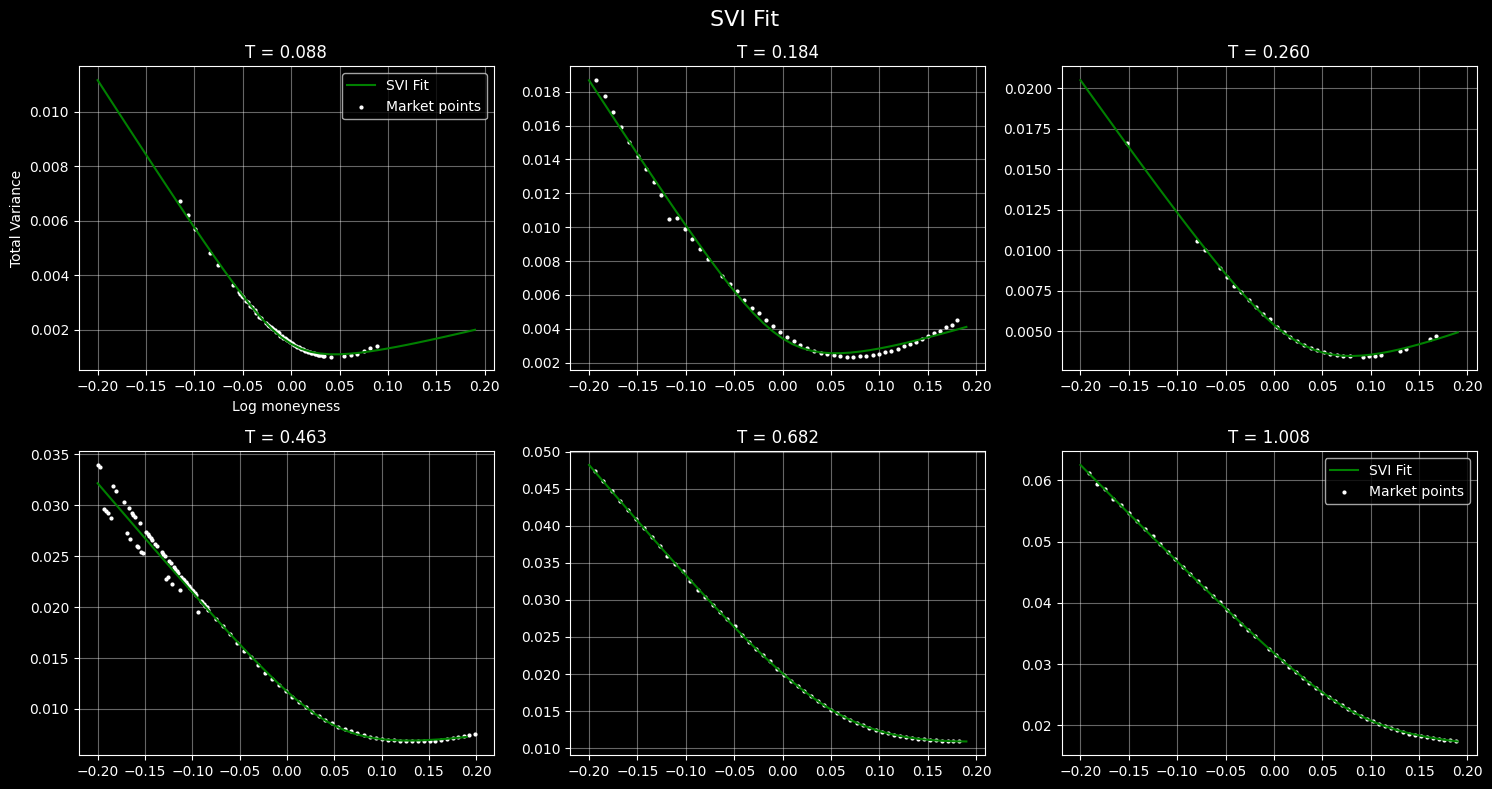

In [225]:
fit_check(work_book, unique_T, slices_list_no_norm)

The naive fit results in decent curves for maturities 3M, 8M and 1Y. Maturities 1M and 2M highlight well the rationale for using a normalisation parameter : the left wing of the smile sways the fit to focus on points with higher implied volatility, resulting in a weaker fit on the right wing which have lower total implied volatility.

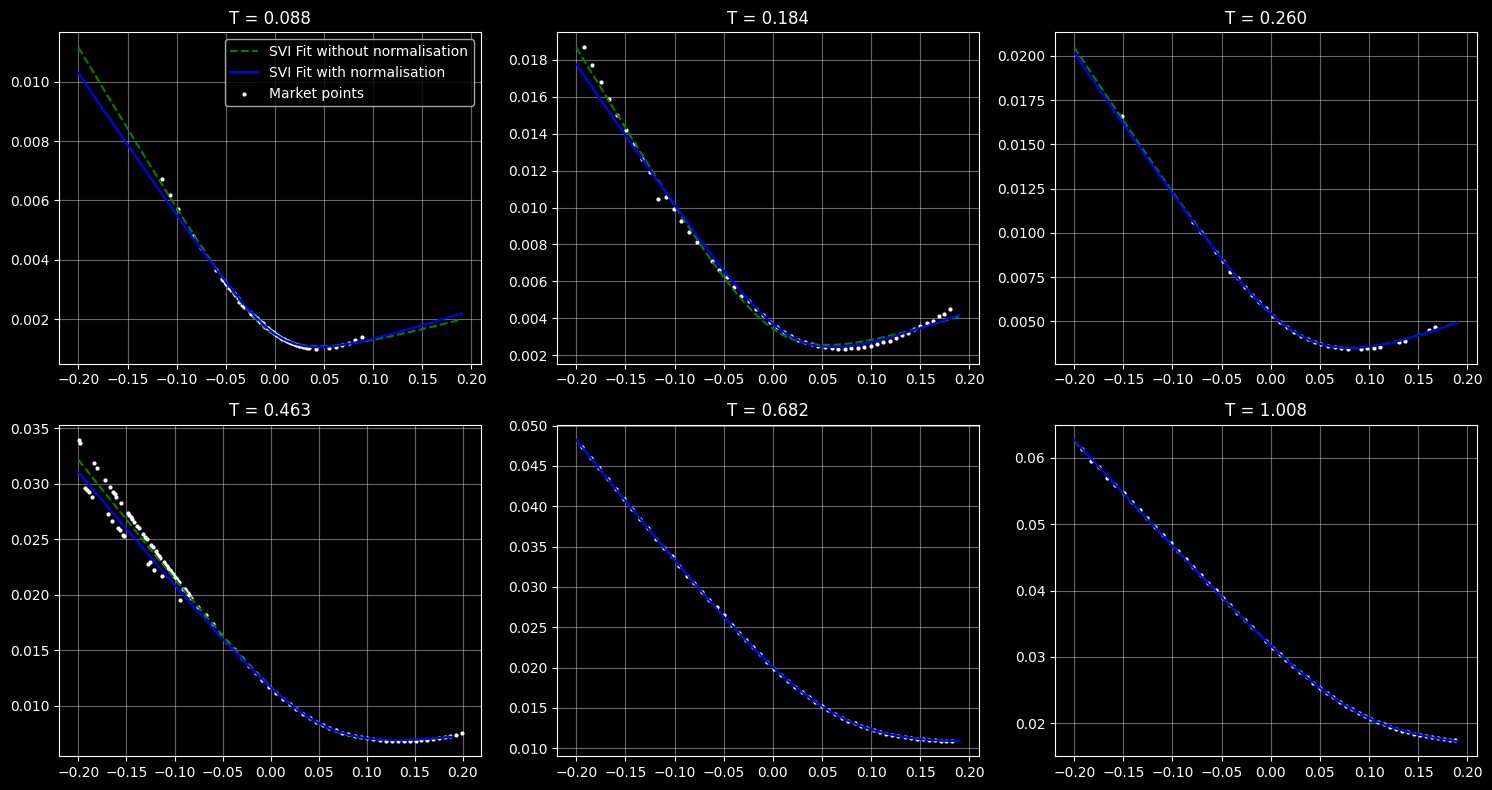

In [226]:
lm_range = np.arange(-0.2, 0.2, 0.01)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i,t in enumerate(unique_T):
    ax = axes[i]
    t = unique_T[i]
    fit_params_norm = slices_list_with_norm[t].params
    fit_params_no_norm = slices_list_no_norm[t].params
    sub = work_book[work_book.T == t]
    fit_norm = svi.svi_total_variance(lm_range, *fit_params_norm)
    fit_no_norm = svi.svi_total_variance(lm_range, *fit_params_no_norm)
    ax.plot(lm_range, fit_no_norm, color="green", label="SVI Fit without normalisation", linestyle = "--")
    ax.plot(lm_range, fit_norm, color="blue", label="SVI Fit with normalisation")
    
    ax.scatter(
        sub.LM,
        sub.W,
        color="white",
        s=4,
        label="Market points"
    )
    ax.set_title(f"T = {t:.3f}")
    ax.grid(alpha=0.4)
    if i == 0:
        ax.legend()
plt.tight_layout()
plt.show()

In [227]:
lm_range = np.arange(-0.2, 0.2, 0.01)

fig = go.Figure()

for i, t in enumerate(unique_T):
    params_norm = slices_list_with_norm[t].params
    params_no_norm = slices_list_no_norm[t].params

    w_norm = svi.svi_total_variance(lm_range, *params_norm)
    w_no_norm = svi.svi_total_variance(lm_range, *params_no_norm)

    T_line = np.full_like(lm_range, t)

    r_spread = work_book.spread / work_book.market_prices


    fig.add_trace(
        go.Scatter3d(
            x=lm_range,
            y=T_line,
            z=w_no_norm,
            mode="lines",
            line=dict(color="green", width=4, dash="dash"),
            name="SVI fit without normalisation" if i == 0 else None,
            showlegend=(i == 0)
        )
    )

    fig.add_trace(
        go.Scatter3d(
            x=lm_range,
            y=T_line,
            z=w_norm,
            mode="lines",
            line=dict(color="lightblue", width=5),
            name="SVI fit with normalisation" if i == 0 else None,
            showlegend=(i == 0)
        )
    )

fig.add_trace(
    go.Scatter3d(
        x=work_book.LM,
        y=work_book.T,
        z=work_book.W,
        mode="markers",
        marker=dict(
            size=4,

            
        ),
        name="Market points")
)
fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k",
        yaxis_title="Maturity T",
        zaxis_title="Total variance w",

        aspectmode="manual",
        aspectratio=dict(x=2, y=1, z=1)
    ),
    height=900,
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=0.02
    )
)
fig.show()


### Fit Error Measurement 

In [228]:
## Global Error 

errors_no_w = {}
errors_w = {}

for i, t in enumerate(unique_T):
    sub_book = work_book[work_book.T == t]
    errors_no_w[t] = (svi.svi_error(sub_book, slices_list_no_norm[t].params))
    errors_w[t] = (svi.svi_error(sub_book, slices_list_with_norm[t].params))


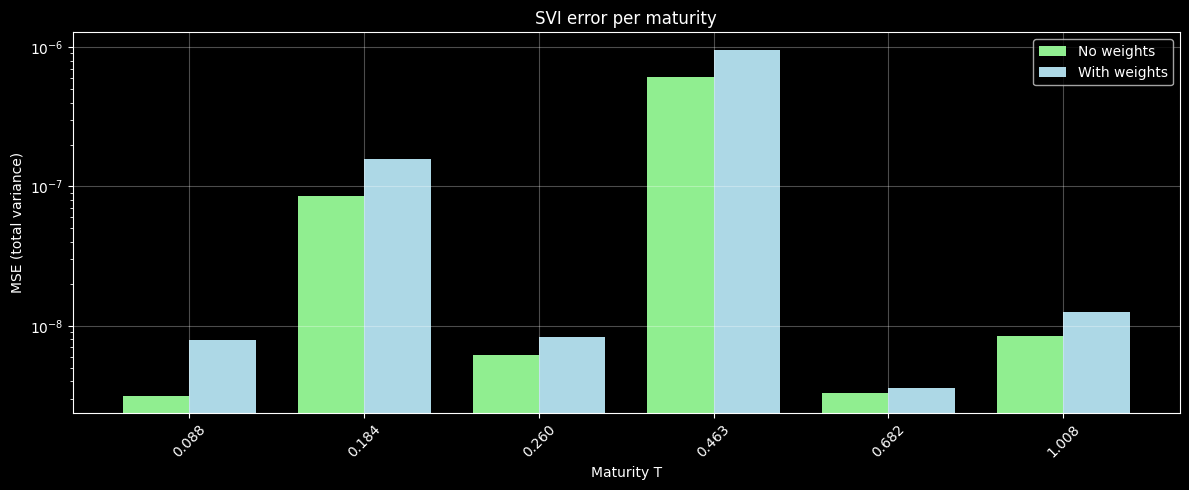

In [229]:
T = np.array(sorted(errors_no_w.keys()), dtype=float)
y_no = np.array([errors_no_w[t] for t in T], dtype=float)
y_w  = np.array([errors_w[t]   for t in T], dtype=float)

x = np.arange(len(T))
width = 0.38

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, y_no, width=width, label="No weights", color = "lightgreen")
plt.bar(x + width/2, y_w,  width=width, label="With weights", color = "lightblue")

plt.xticks(x, [f"{t:.3f}" for t in T], rotation=45)
plt.xlabel("Maturity T")
plt.ylabel("MSE (total variance)")
plt.yscale("log")
plt.title("SVI error per maturity")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [230]:
## Global Error 

errors_no_w_atm = {}
errors_w_atm = {}
book_atm = work_book[(work_book.LM < 0.02) & (work_book.LM > -0.02)]

for i, t in enumerate(unique_T):
    sub_book = book_atm[book_atm.T == t]
    errors_no_w_atm[t] = (svi.svi_error(sub_book, slices_list_no_norm[t].params))
    errors_w_atm[t] = (svi.svi_error(sub_book, slices_list_with_norm[t].params))

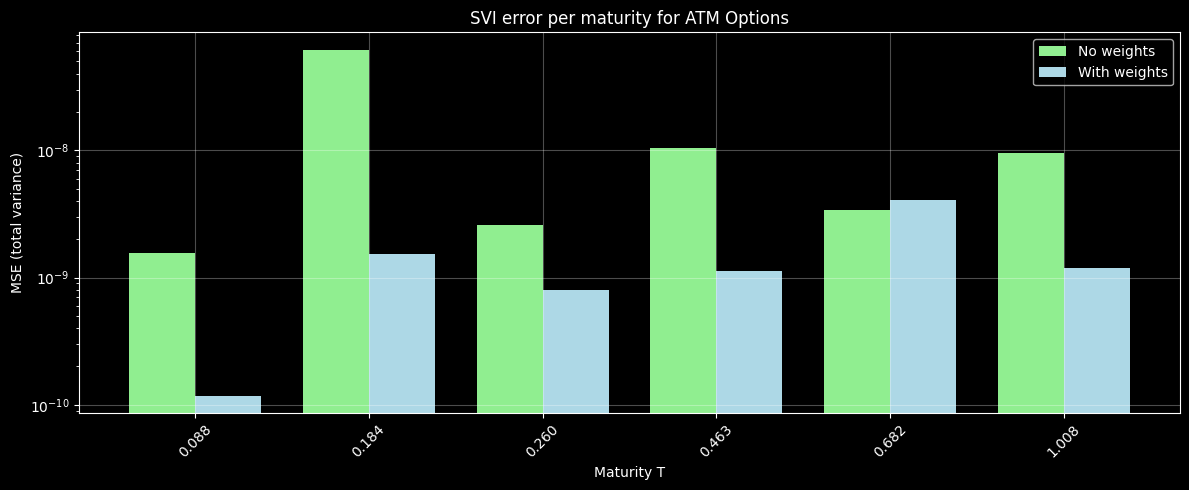

In [231]:
T = np.array(sorted(errors_no_w_atm.keys()), dtype=float)
y_no = np.array([errors_no_w_atm[t] for t in T], dtype=float)
y_w  = np.array([errors_w_atm[t]   for t in T], dtype=float)

x = np.arange(len(T))
width = 0.38

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, y_no, width=width, label="No weights", color = "lightgreen")
plt.bar(x + width/2, y_w,  width=width, label="With weights", color = "lightblue")

plt.xticks(x, [f"{t:.3f}" for t in T], rotation=45)
plt.xlabel("Maturity T")
plt.ylabel("MSE (total variance)")
plt.yscale("log")
plt.title("SVI error per maturity for ATM Options")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Time Derivative with SVI 

In [232]:
slices_list_no_norm

{0.08767123287671233: SVISlice(a=1.2181174252667768e-13, b=0.03261274985725408, rho=-0.7149470044687621, m=-0.003732411691844861, sigma=0.04765090650979555, T=0.08767123287671233),
 0.18356164383561643: SVISlice(a=1.2138075478947938e-22, b=0.054519908480365545, rho=-0.6521941602416399, m=0.0017274487282740267, sigma=0.061700022265402076, T=0.18356164383561643),
 0.2602739726027397: SVISlice(a=5.4566183518807464e-17, b=0.05562421603197246, rho=-0.5481361430991053, m=0.030188405187312334, sigma=0.07495890880416071, T=0.2602739726027397),
 0.46301369863013697: SVISlice(a=0.0038118397383106388, b=0.06379751865129028, rho=-0.7382762651805246, m=0.04979235602998417, sigma=0.07178167413777123, T=0.46301369863013697),
 0.6821917808219178: SVISlice(a=0.005164204164827665, b=0.08870292176686999, rho=-0.784523467437975, m=0.06070600150525706, sigma=0.10428438892323755, T=0.6821917808219178),
 1.0082191780821919: SVISlice(a=0.014934701647431848, b=0.08126162786844279, rho=-0.9989971507262739, m=0.

In [233]:
K_grid = np.linspace(work_book.K.min(), work_book.K.max(), 1000)

calendar_violations = []

Ts = sorted(maturities.values())   # tri par T (floats)
call_prices = {}

for T in Ts:
    sub_book = work_book[work_book.T == T]

    F = sub_book.F[0]
    r = sub_book.r[0]

    svi_slice = slices_list_no_norm[T]  # indexé par T

    k = np.log(K_grid / F)

    w = svi.svi_total_variance(k, *svi_slice.params)
    sigma = np.sqrt(w / T)

    C = np.array([
    bs.black_scholes(call, S=F, K=K, T=T, sigma=sig, r=r)
    for K, sig in zip(K_grid, sigma)
])


    call_prices[T] = C


for i in range(len(Ts) - 1):
    T1, T2 = Ts[i], Ts[i + 1]
    C1, C2 = call_prices[T1], call_prices[T2]

    mask = C2 < C1

    if np.any(mask):
        calendar_violations.append({
            "T1": T1,
            "T2": T2,
            "num_violations": int(mask.sum()),
            "max_violation": float(np.max(C1[mask] - C2[mask]))
        })


for v in calendar_violations:
    print(
        f"Calendar arbitrage between T={v['T1']:.6f} and T={v['T2']:.6f} | "
        f"{v['num_violations']} strikes | "
        f"max diff = {v['max_violation']:.4e}"
    )



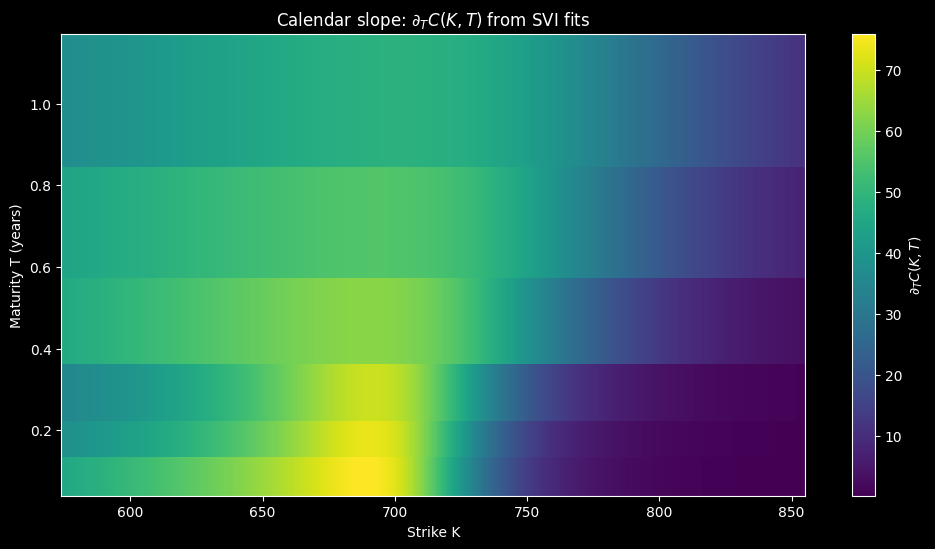

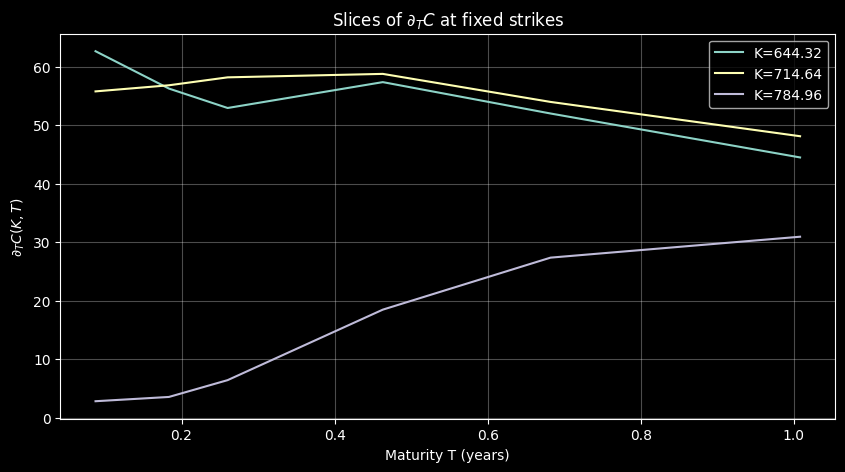

In [ ]:
%matplotlib inline

K_grid = np.linspace(work_book.K.min(), work_book.K.max(), 1000)

Ts = sorted(maturities.values())


C_mat = np.zeros((len(Ts), len(K_grid)))

for j, T in enumerate(Ts):
    sub_book = work_book[work_book.T == T]

    F = sub_book.F[0]
    r = sub_book.r[0]

    svi_slice = slices_list_no_norm[T]  

    k = np.log(K_grid / F)
    w = svi.svi_total_variance(k, *svi_slice.params)
    sigma = np.sqrt(w / T)

    C = np.array([
        bs.black_scholes(call, S=F, K=K, T=T, sigma=sig, r=r)
        for K, sig in zip(K_grid, sigma)
    ])

    C_mat[j, :] = C


dC_dT = np.gradient(C_mat, Ts, axis=0)

plt.figure(figsize=(12, 6))
plt.pcolormesh(K_grid, Ts, dC_dT, shading="auto")
plt.colorbar(label=r"$\partial_T C(K,T)$")
plt.xlabel("Strike K")
plt.ylabel("Maturity T (years)")
plt.title(r"Calendar slope: $\partial_T C(K,T)$ from SVI fits")
plt.show()

Ks_show = [K_grid[250], K_grid[500], K_grid[750]]
plt.figure(figsize=(10, 5))
for K0 in Ks_show:
    idx = np.argmin(np.abs(K_grid - K0))
    plt.plot(Ts, dC_dT[:, idx], label=f"K={K_grid[idx]:.2f}")
plt.grid(alpha=0.3)
plt.xlabel("Maturity T (years)")
plt.ylabel(r"$\partial_T C(K,T)$")
plt.title(r"Slices of $\partial_T C$ at fixed strikes")
plt.legend()
plt.show()


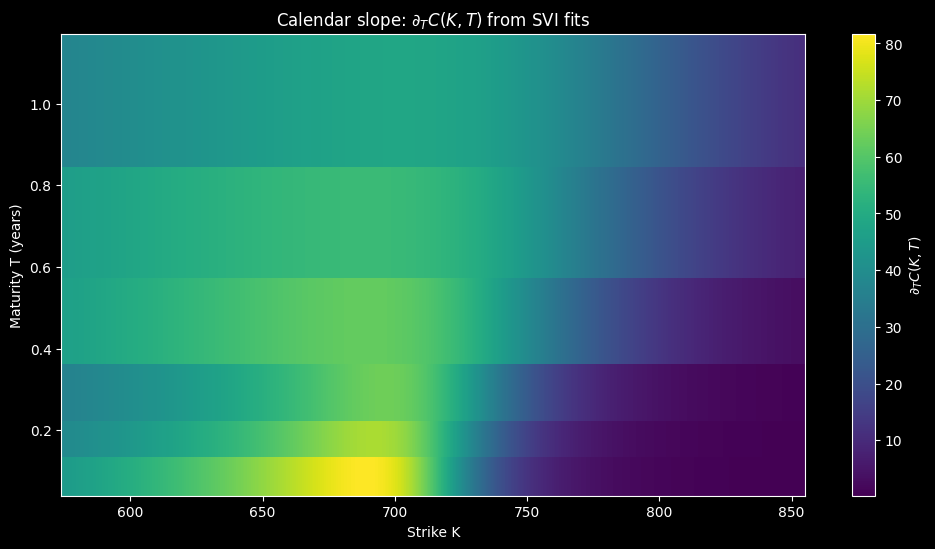

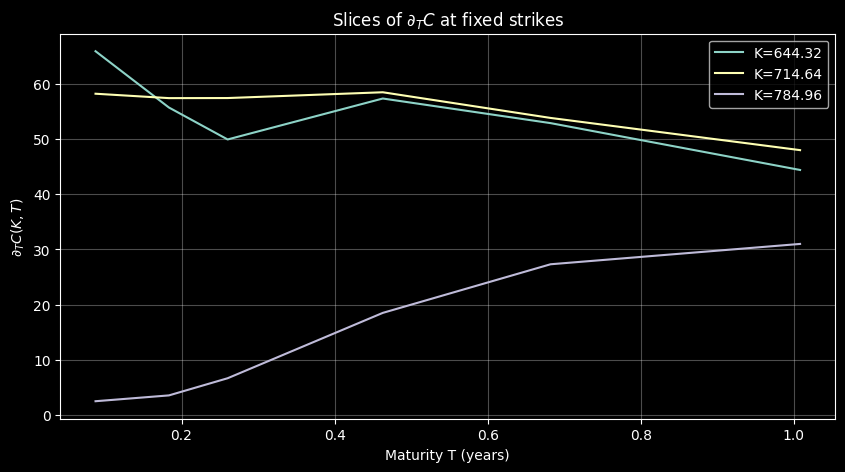

In [ ]:
%matplotlib inline

k_svi_plot = {}


for j, T in enumerate(Ts):
    sub_book = work_book[work_book.T == T]

    F = sub_book.F[0]
    r = sub_book.r[0]

    svi_slice = slices_list_with_norm[T] 

    k = np.log(K_grid / F)
    w = svi.svi_total_variance(k, *svi_slice.params)
    sigma = np.sqrt(w / T)

    C = np.array([
        bs.black_scholes(call, S=F, K=K, T=T, sigma=sig, r=r)
        for K, sig in zip(K_grid, sigma)
    ])

    C_mat[j, :] = C

dC_dT = np.gradient(C_mat, Ts, axis=0)

plt.figure(figsize=(12, 6))
plt.pcolormesh(K_grid, Ts, dC_dT, shading="auto")
plt.colorbar(label=r"$\partial_T C(K,T)$")
plt.xlabel("Strike K")
plt.ylabel("Maturity T (years)")
plt.title(r"Calendar slope: $\partial_T C(K,T)$ from SVI fits")
plt.show()

Ks_show = [K_grid[250], K_grid[500], K_grid[750]]
plt.figure(figsize=(10, 5))
for K0 in Ks_show:
    idx = np.argmin(np.abs(K_grid - K0))
    plt.plot(Ts, dC_dT[:, idx], label=f"K={K_grid[idx]:.2f}")
plt.grid(alpha=0.3)
plt.xlabel("Maturity T (years)")
plt.ylabel(r"$\partial_T C(K,T)$")
plt.title(r"Slices of $\partial_T C$ at fixed strikes")
plt.legend()
plt.show()


## Volatility Surface Interpolation

The objective now will be to interpolate between the fits to derive a volatility surface. 

In [236]:

from scipy.interpolate import PchipInterpolator

K_grid = np.linspace(work_book.K.min(), work_book.K.max(), 1000)
Ts = sorted(maturities.values())
T_fine = np.linspace(Ts[0], Ts[-1], 250)

C_mat = np.zeros((len(Ts), len(K_grid)))

for iT, T in enumerate(Ts):
    sub_book = work_book[work_book.T == T]
    F = sub_book.F[0]
    r = sub_book.r[0]

    svi_slice = slices_list_with_norm[T]
    k = np.log(K_grid / F)
    w = svi.svi_total_variance(k, *svi_slice.params)
    sigma = np.sqrt(w / T)

    C_mat[iT, :] = np.array([
        bs.black_scholes(call, S=F, K=K, T=T, sigma=sig, r=r) for K, sig in zip(K_grid, sigma)
    ])


In [253]:
K_mesh, T_mesh = np.meshgrid(K_grid, Ts) # shapes: (nT, nK) 
K_flat = K_mesh.ravel() 
T_flat = T_mesh.ravel() 
C_flat = C_mat.ravel()

fig = go.Figure(
    data=go.Scatter3d(
        x=K_flat,
        y=T_flat,
        z=C_flat,
        mode="markers",
        marker=dict(
            size=2,
            color=C_flat,
            colorscale="Portland",
            opacity=0.8
        )
    )
)

fig.update_layout(
    title="Call price points C(K,T)",
    template="plotly_dark",
    scene=dict(
        xaxis_title="K",
        yaxis_title="T",
        zaxis_title="C",
        aspectmode="manual",
        aspectratio=dict(x=1.5, y=1, z=1)
    ),
    height=800
)

fig.show()



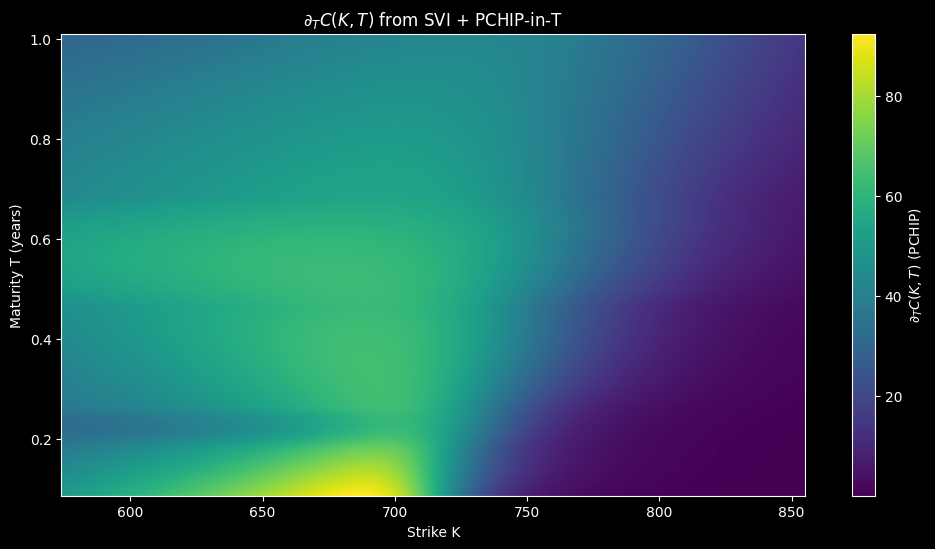

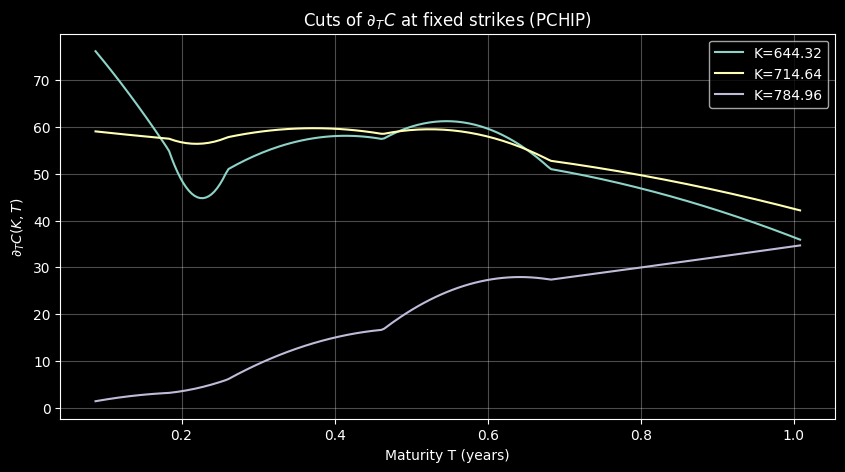

In [238]:


C_fine = np.zeros((len(T_fine), len(K_grid)))
dC_dT_fine = np.zeros((len(T_fine), len(K_grid)))

for jK in range(len(K_grid)):
    p = PchipInterpolator(Ts, C_mat[:, jK])
    C_fine[:, jK] = p(T_fine)
    dC_dT_fine[:, jK] = p.derivative()(T_fine)

plt.figure(figsize=(12, 6))
plt.pcolormesh(K_grid, T_fine, dC_dT_fine, shading="auto")
plt.colorbar(label=r"$\partial_T C(K,T)$ (PCHIP)")
plt.xlabel("Strike K")
plt.ylabel("Maturity T (years)")
plt.title(r"$\partial_T C(K,T)$ from SVI + PCHIP-in-T")
plt.show()

Ks_show = [K_grid[250], K_grid[500], K_grid[750]]
plt.figure(figsize=(10, 5))
for K0 in Ks_show:
    j = np.argmin(np.abs(K_grid - K0))
    plt.plot(T_fine, dC_dT_fine[:, j], label=f"K={K_grid[j]:.2f}")
plt.grid(alpha=0.3)
plt.xlabel("Maturity T (years)")
plt.ylabel(r"$\partial_T C(K,T)$")
plt.title(r"Cuts of $\partial_T C$ at fixed strikes (PCHIP)")
plt.legend()
plt.show()


In [255]:

k_grid = np.linspace(work_book.LM.min(), work_book.LM.max(), 250)
Ts = np.array(sorted(maturities.values()))

IV = np.empty((len(Ts), len(k_grid)))

for iT, T in enumerate(Ts):
    params = slices_list_with_norm[T].params
    w = svi.svi_total_variance(k_grid, *params)
    IV[iT, :] = np.sqrt(w / T)

K, TT = np.meshgrid(k_grid, Ts)

fig = go.Figure(
    data=[
        go.Surface(
            x=K,
            y=TT,
            z=IV,
            showscale=True,
            colorscale = "Portland",
        
            name="IV surface (SVI + norm)",
        )
    ]
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k",
        yaxis_title="Maturity T",
        zaxis_title="Implied volatility σ",
        aspectmode="manual",
        aspectratio=dict(x=1, y=1, z=1),
    ),
    height=900,
)

fig.show()


In [240]:

W = np.empty((len(Ts), len(k_grid)))

for iT, T in enumerate(Ts):
    params = slices_list_with_norm[T].params
    W[iT, :] = svi.svi_total_variance(k_grid, *params)

K, TT = np.meshgrid(k_grid, Ts)

fig = go.Figure(
    data=[
        go.Surface(
            x=K,
            y=TT,
            z=W,
            showscale=True,
                        colorscale = "Portland",
        
            name="Total variance surface (SVI + norm)",
        )
    ]
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Log-moneyness k",
        yaxis_title="Maturity T",
        zaxis_title="Total variance w",
        aspectmode="manual",
        aspectratio=dict(x=1, y=1, z=1),
    ),
    height=900,
)

fig.show()


Dupire's formula is the following :

$$

\sigma_{loc}^2(K,T) = \frac{\partial_T C(K,T) + r(T)\space K\space \partial_K C(K,T)}{\frac{1}{2} K^2 \partial_{KK} C(K,T)}

$$

We assumed $r$ constant in this work at 2%. Hence, $r(T) = 0.2 \space \forall \space T$. The implementation of `r_fine = PchipInterpolator(Ts, r_vec)(T_fine)` is kept for the example.

In [ ]:
K_grid = np.linspace(work_book.K.min(), work_book.K.max(), 600)
T_fine = np.linspace(Ts[0], Ts[-1], 220)

C_mat = np.zeros((len(Ts), len(K_grid)))
r_vec = np.zeros(len(Ts))

for iT, T in enumerate(Ts):
    sub = work_book[work_book.T == T]
    F = sub.F[0]
    r = sub.r[0]

    svi_slice = slices_list_with_norm[T]
    k = np.log(K_grid / F)
    w = svi.svi_total_variance(k, *svi_slice.params)
    sigma = np.sqrt(w / T)

    C_mat[iT, :] = np.array([
        bs.black_scholes(call, S=F, K=K, T=T, sigma=sig, r=r)
        for K, sig in zip(K_grid, sigma)
    ])

    r_vec[iT] = r

C_fine = np.zeros((len(T_fine), len(K_grid)))
dC_dT_fine = np.zeros((len(T_fine), len(K_grid)))

for jK in range(len(K_grid)):
    p = PchipInterpolator(Ts, C_mat[:, jK])
    C_fine[:, jK] = p(T_fine)
    dC_dT_fine[:, jK] = p.derivative()(T_fine)

r_fine = PchipInterpolator(Ts, r_vec)(T_fine) #interpolation to determine 

dC_dK = numerical.finite_difference(C_fine, K_grid, degree=1, axis=1)
d2C_dK2 = numerical.finite_difference(C_fine, K_grid, degree=2, axis=1)

# --- Dupire ---
K2 = K_grid[None, :] ** 2
den = 0.5 * K2 * d2C_dK2
num = dC_dT_fine + (r_fine[:, None] * K_grid[None, :]) * dC_dK

eps = 1e-14
sigma_loc2 = num / (den + eps)

sigma_loc2[~np.isfinite(sigma_loc2)] = np.nan
sigma_loc2[sigma_loc2 < 0] = np.nan
sigma_loc2[d2C_dK2 <= 0] = np.nan



<>:12: SyntaxWarning:

invalid escape sequence '\p'

<>:12: SyntaxWarning:

invalid escape sequence '\p'

/var/folders/lj/pf9bnzv91ysg72jyt5kf0v7w0000gn/T/ipykernel_66987/2876862075.py:12: SyntaxWarning:

invalid escape sequence '\p'



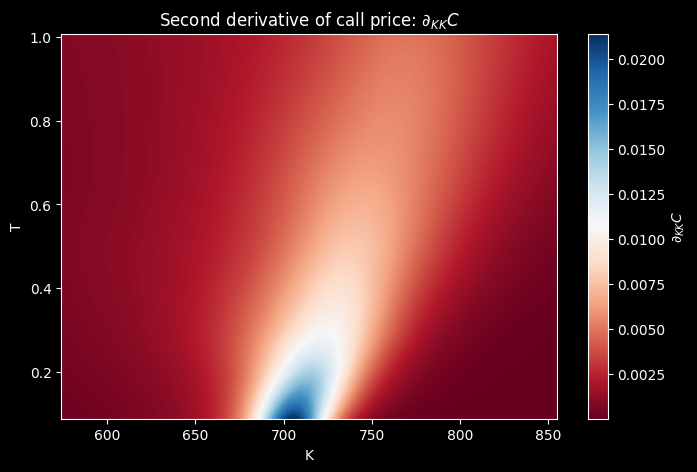

In [ ]:
plt.figure(figsize=(8, 5))
plt.imshow(
    d2C_dK2,
    aspect="auto",
    origin="lower",
    extent=[K_grid.min(), K_grid.max(), T_fine.min(), T_fine.max()],
    cmap="RdBu",
)
plt.colorbar(label=r"$\partial_{KK} C$")
plt.xlabel("K")
plt.ylabel("T")
plt.title("Second derivative of call price: $ \partial_{KK} C$")
plt.show()

In [243]:

sigma_loc = np.sqrt(sigma_loc2)

K_mesh, T_mesh = np.meshgrid(K_grid, T_fine)

fig = go.Figure(
    data=[
        go.Surface(
            x=K_mesh,
            y=T_mesh,
            z=sigma_loc,
            showscale=True,
                     colorscale = "Portland",
            name="Local vol (Dupire)"
        )
    ]
)

fig.update_layout(
    template="plotly_dark",
    scene=dict(
        xaxis_title="Strike K",
        yaxis_title="Maturity T",
        zaxis_title="Local volatility σ_loc",
        xaxis=dict(range=[575, 850])
    ),
    height=900,
)

fig.show()
